In [ ]:
!pip install -q torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 960.9/960.9 kB 22.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 112.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 80.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 61.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 100.6 MB/s eta 0:00:00


In [ ]:
## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from torch.utils.data import Subset
import torchmetrics
from torchmetrics.detection.mean_ap import MeanAveragePrecision

## Torchvision
import torchvision
from torchvision import tv_tensors
from torchvision.datasets import ImageFolder
from torchvision.transforms import v2 as T
from torchvision.ops import nms, box_iou

## other libraries
import os
import glob
import kagglehub
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import xml.etree.ElementTree as ET
from PIL import Image
from sklearn.metrics import confusion_matrix

---
# **Utils**
---


In [ ]:
# Function to visualize a batch
def visualize_batch(dataloader):
    images, _, raw_bboxes = next(iter(dataloader))
    fig, axes = plt.subplots(1, len(images), figsize=(15, 5))

    if len(images) == 1:
        axes = [axes]

    for i, (img, bbox) in enumerate(zip(images, raw_bboxes)):
        img = img.permute(1, 2, 0).numpy()
        axes[i].imshow(img)

        for box in bbox:
            label, xmin, ymin, xmax, ymax = map(int, box)
            rect = patches.Rectangle(
                (xmin, ymin),
                xmax - xmin,
                ymax - ymin,
                linewidth=3,
                edgecolor="r",
                facecolor="none",
            )
            axes[i].add_patch(rect)
            axes[i].text(
                xmin,
                ymin - 5,
                f"Label: {label}",
                color="red",
                fontsize=10,
                bbox=dict(facecolor="white", alpha=0.5),
            )
        axes[i].axis("off")

    plt.show()

In [ ]:
def plot_loss(train_losses, val_losses):
    """
    plot training and validation loss per epoch
    train_losses: training losses per epoch
    val_losses: validation losses per epoch
    """
    epochs = len(train_losses)
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, epochs + 1), train_losses, label="Train Loss")
    plt.plot(range(1, epochs + 1), val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss per Epoch")
    plt.legend()
    plt.show()
    plt.close()

In [ ]:
def plot_components(list_components_dicts):

    keys = list(list_components_dicts[0].keys())
    components = {k: [] for k in keys}

    for epoch in list_components_dicts:
        for k in keys:
            components[k].append(epoch[k])

    plt.figure(figsize=(10, 5))
    for component, values in components.items():
        plt.plot(range(1, len(values) + 1), values, label=component)

    plt.xlabel("Epoch")
    plt.ylabel("Loss Value")
    plt.title("Loss Components Over Epochs")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
def lr_scheduler(optimizer, epoch=0):
    """
    function that decreases optimizer's learning rate every 5 epochs
    of training by half
    """
    if epoch > 0 and epoch % 5 == 0:
        for param_group in optimizer.param_groups:
            param_group["lr"] *= 0.5
        print("Learning rate decreased")
    return optimizer

In [ ]:
def plot_miss(mistakes, num=5):
    for image, label, true_box, pred_label, pred_box in mistakes[0:num]:
        image = image.permute(1, 2, 0).numpy()
        plt.figure(figsize=(5, 5))
        plt.imshow(image)

        # true box
        plt.gca().add_patch(
            patches.Rectangle(
                (true_box[0], true_box[1]),  # xmin, ymin
                true_box[2] - true_box[0],  # width
                true_box[3] - true_box[1],  # height
                linewidth=2,
                edgecolor="green",
                facecolor="none",
            )
        )

        # predicted box
        plt.gca().add_patch(
            patches.Rectangle(
                (pred_box[0], pred_box[1]),
                pred_box[2] - pred_box[0],
                pred_box[3] - pred_box[1],
                linewidth=2,
                edgecolor="red",
                facecolor="none",
            )
        )

        plt.axis("off")
        plt.title(f"True: {label}, Pred: {pred_label}")
        plt.show()

In [ ]:
def yolo_to_xyxy(i, j, x, y, w, h):
    """
    convert from yolo format to xyxy
    """
    # to absolute image coords
    cx = (j + x.item()) / 7
    cy = (i + y.item()) / 7
    bw = w.item()
    bh = h.item()

    xmin = (cx - bw / 2) * 112
    ymin = (cy - bh / 2) * 112
    xmax = (cx + bw / 2) * 112
    ymax = (cy + bh / 2) * 112
    return xmin, ymin, xmax, ymax

In [ ]:
def to_dicts(preds, targets, conf=0.3, iou=0.4):

    pred_list = []
    target_list = []

    for b in range(preds.shape[0]):
        boxes, t_boxes = [], []
        labels, t_labels = [], []
        scores = []
        pred = preds[b]
        target = targets[b]
        for i in range(7):
            for j in range(7):
                cell = pred[i, j]
                t_cell = target[i, j]
                objectness = torch.sigmoid(cell[0])

                if objectness > conf:
                    x, y = torch.sigmoid(cell[1]), torch.sigmoid(cell[2])
                    w, h = cell[3], cell[4]
                    class_probs = torch.sigmoid(cell[5:])
                    class_score, label = torch.max(class_probs, dim=0)

                    xmin, ymin, xmax, ymax = yolo_to_xyxy(i, j, x, y, w, h)

                    boxes.append([xmin, ymin, xmax, ymax])
                    scores.append(objectness.item())
                    labels.append(label.item())

                if t_cell[0] == 1:
                    x, y = t_cell[1], t_cell[2]
                    w, h = t_cell[3], t_cell[4]
                    xmin, ymin, xmax, ymax = yolo_to_xyxy(i, j, x, y, w, h)
                    t_boxes.append([xmin, ymin, xmax, ymax])
                    t_labels.append(t_cell[5:].argmax().item())

        boxes = (
            torch.tensor(boxes) if boxes else torch.empty((0, 4), dtype=torch.float32)
        )
        scores = (
            torch.tensor(scores) if scores else torch.empty((0,), dtype=torch.float32)
        )
        labels = (
            torch.tensor(labels) if labels else torch.empty((0,), dtype=torch.int64)
        )
        t_boxes = (
            torch.tensor(t_boxes)
            if t_boxes
            else torch.empty((0, 4), dtype=torch.float32)
        )
        t_labels = (
            torch.tensor(t_labels) if t_labels else torch.empty((0,), dtype=torch.int64)
        )

        pred_list.append({"boxes": boxes, "scores": scores, "labels": labels})
        target_list.append({"boxes": t_boxes, "labels": t_labels})

    return pred_list, target_list

In [ ]:
def conf_matrix(pred_list, target_list, images, iou=0.4):
    """
    calculate confusion matrix
    """
    cm = torch.zeros(3, 3, dtype=torch.int64)
    mistakes = []
    for idx, (pred, target) in enumerate(zip(pred_list, target_list)):
        true_boxes = target["boxes"]
        true_labels = target["labels"]

        pred_boxes = pred["boxes"]
        pred_labels = pred["labels"]

        if len(true_labels) == 0:
            continue  # skip if no true object

        true_label = true_labels[0].item()
        true_box = true_boxes[0].unsqueeze(0)  # [1, 4]

        predicted_class = 2  # default: no-detection

        for i in range(len(pred_boxes)):
            box = pred_boxes[i].unsqueeze(0)
            label = pred_labels[i].item()

            ious = box_iou(box, true_box).item()
            if ious >= iou:
                predicted_class = label
                # save mistakes to plot for choice task
                if predicted_class != true_label:
                    mistakes.append(
                        (
                            images[idx].cpu(),
                            true_label,
                            true_boxes[0],
                            predicted_class,
                            pred_boxes[i],
                        )
                    )
                    break

        cm[true_label][predicted_class] += 1

    return cm, mistakes

---
# **Architecture**
---


In [ ]:
class YOLO_like(nn.Module):
    def __init__(self, output=343):
        super().__init__()
        self.weights_init()
        self.output = output
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.conv5 = nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(32)
        self.pool = nn.AvgPool2d(kernel_size=(2, 2), stride=2, padding=0)
        self.flat = nn.Flatten()
        self.drop = nn.Dropout(0.2)
        self.fc1 = nn.Linear(32 * 7 * 7, 512)
        self.fc2 = nn.Linear(512, self.output)

    # init weights with nn.init.kaiming_normal
    def weights_init(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity="relu")

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.bn1(x)
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.bn2(x)
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.bn3(x)
        x = self.pool(x)
        x = F.relu(self.conv4(x))
        x = self.bn4(x)
        x = self.pool(x)
        x = F.relu(self.conv5(x))
        x = self.bn5(x)
        x = self.flat(x)
        x = self.drop(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

---
# **Data**
---


In [ ]:
# Download latest version
path = kagglehub.dataset_download("andrewmvd/dog-and-cat-detection")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/andrewmvd/dog-and-cat-detection/versions/1


In [ ]:
!cp -rf $path ./cat_dog_dataset

In [ ]:
class CatDogDataset(Dataset):
    def __init__(self, img_dir, ann_dir, grid_size=7, num_classes=2, transform=None):
        self.img_dir = img_dir
        self.ann_dir = ann_dir
        self.transform = transform
        self.img_files = sorted(glob.glob(os.path.join(img_dir, "*.png")))
        self.ann_files = sorted(glob.glob(os.path.join(ann_dir, "*.xml")))
        self.label_map = {"cat": 0, "dog": 1}  # Label mapping
        self.S = grid_size
        self.C = num_classes

    def parse_annotation(self, ann_path):
        tree = ET.parse(ann_path)
        root = tree.getroot()
        width = int(root.find("size/width").text)
        height = int(root.find("size/height").text)
        objects = []

        for obj in root.findall("object"):
            name = obj.find("name").text
            xmin = int(obj.find("bndbox/xmin").text)
            ymin = int(obj.find("bndbox/ymin").text)
            xmax = int(obj.find("bndbox/xmax").text)
            ymax = int(obj.find("bndbox/ymax").text)

            label = self.label_map.get(name, -1)  # Default to -1 if unknown label
            objects.append({"label": label, "bbox": [xmin, ymin, xmax, ymax]})

        return width, height, objects

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_path = self.img_files[idx]
        ann_path = self.ann_files[idx]

        image = Image.open(img_path).convert("RGB")
        width, height, objects = self.parse_annotation(ann_path)

        yolo_boxes = []  # to store boxes in yolo format
        for obj in objects:
            xmin, ymin, xmax, ymax = obj["bbox"]
            x_c = (xmin + xmax) / 2.0
            y_c = (ymin + ymax) / 2.0
            w = xmax - xmin
            h = ymax - ymin
            yolo_boxes.append([x_c, y_c, w, h])

        # to tensors
        yolo_boxes = torch.tensor(yolo_boxes, dtype=torch.float32)
        image = tv_tensors.Image(torchvision.transforms.functional.pil_to_tensor(image))
        boxes = tv_tensors.BoundingBoxes(
            yolo_boxes, format="CXCYWH", canvas_size=(height, width)
        )

        # transforms
        if self.transform:
            image, boxes = self.transform(image, boxes)

        # YOLO encoding
        target = torch.zeros((self.S, self.S, 5 + self.C))
        for i, box in enumerate(boxes):
            label = objects[i]["label"]

            # normalize coords
            x_c = box[0].item() / image.shape[2]  # could replace image.shape by 112
            y_c = box[1].item() / image.shape[1]  # since these are resized images
            w = box[2].item() / image.shape[2]
            h = box[3].item() / image.shape[1]

            grid_x, grid_y = int(x_c * self.S), int(y_c * self.S)
            # grid cell coords

            if target[grid_y, grid_x, 0] == 0:
                x_cell = x_c * self.S - grid_x  # relative to the cell
                y_cell = y_c * self.S - grid_y
                target[grid_y, grid_x, 0] = 1.0  # conf
                target[grid_y, grid_x, 1:5] = torch.tensor(
                    [x_cell, y_cell, w, h]
                )  # cell relative coords
                target[grid_y, grid_x, 5 + label] = 1.0  # class probability

        return image, target

In [ ]:
# transformations for training data
transform = T.Compose(
    [
        T.Resize((112, 112)),
        T.RandomRotation(degrees=20),
        T.RandomHorizontalFlip(p=0.5),
        T.RandomPhotometricDistort(hue=(0, 0), p=0.2),
        T.ToDtype(torch.float32, scale=True),
    ]
)
# for val, test
base_transform = T.Compose(
    [
        T.Resize((112, 112)),
        T.ToDtype(torch.float32, scale=True),
    ]
)
# full dataset
dataset = CatDogDataset(
    img_dir="/content/cat_dog_dataset/images",
    ann_dir="/content/cat_dog_dataset/annotations",
    transform=None,
)
# we use 80, 10, 10 split
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    range(len(dataset)), [0.8, 0.1, 0.1]
)
# apply different transforms (data aug in training)
train_dataset = Subset(
    CatDogDataset(
        img_dir="/content/cat_dog_dataset/images",
        ann_dir="/content/cat_dog_dataset/annotations",
        transform=transform,
    ),
    train_dataset,
)
val_dataset = Subset(
    CatDogDataset(
        img_dir="/content/cat_dog_dataset/images",
        ann_dir="/content/cat_dog_dataset/annotations",
        transform=base_transform,
    ),
    val_dataset,
)
test_dataset = Subset(
    CatDogDataset(
        img_dir="/content/cat_dog_dataset/images",
        ann_dir="/content/cat_dog_dataset/annotations",
        transform=base_transform,
    ),
    test_dataset,
)
# dataloaders
train_dl = DataLoader(
    train_dataset, batch_size=64, shuffle=True, collate_fn=lambda x: tuple(zip(*x))
)
val_dl = DataLoader(
    val_dataset, batch_size=64, shuffle=True, collate_fn=lambda x: tuple(zip(*x))
)
test_dl = DataLoader(
    test_dataset, batch_size=64, shuffle=True, collate_fn=lambda x: tuple(zip(*x))
)

# visualize_batch(train_dl)

---
#  **YOLOv1 Loss**
---


In [ ]:
class YOLO_loss(nn.Module):
    def __init__(self, num_classes=2, l_coord=5, l_noobj=0.5):
        super().__init__()
        self.l_coord = l_coord
        self.l_noobj = l_noobj
        self.S = 7
        self.B = 1
        self.C = num_classes
        self.mse = nn.MSELoss()

    def forward(self, predictions, target):
        pred_conf = torch.sigmoid(predictions[..., 0:1])  # conf/ objectness
        pred_xy = torch.sigmoid(predictions[..., 1:3])  # x, y
        pred_wh = predictions[..., 3:5]  # w, h (raw)
        pred_cls = torch.sigmoid(predictions[..., 5:])  # class probs (last 2)

        # true values
        true_conf = target[..., 0:1]
        true_xy = target[..., 1:3]
        true_wh = target[..., 3:5]
        true_cls = target[..., 5:]

        obj_mask = true_conf  # (N, 7, 7, 1) 1 in cell where centers exists
        noobj_mask = 1 - obj_mask

        # coord loss (x, y, w, h)
        pred_wh = torch.sign(pred_wh) * torch.sqrt(torch.abs(pred_wh) + 1e-6)
        true_wh = torch.sqrt(torch.abs(true_wh) + 1e-6)

        box_loss = self.mse(obj_mask * pred_xy, obj_mask * true_xy) + self.mse(
            obj_mask * pred_wh, obj_mask * true_wh
        )

        # Objectness Loss
        obj_loss = self.mse(obj_mask * pred_conf, obj_mask * true_conf)

        # No-object Loss
        noobj_loss = self.mse(noobj_mask * pred_conf, noobj_mask * true_conf)

        # Classification Loss
        class_loss = self.mse(obj_mask * pred_cls, obj_mask * true_cls)

        # Total Loss
        loss = (
            self.l_coord * box_loss + obj_loss + self.l_noobj * noobj_loss + class_loss
        )

        components = {
            "box": box_loss.item(),
            "obj": obj_loss.item(),
            "noobj": noobj_loss.item(),
            "class": class_loss.item(),
        }

        return loss, components

---
# **Training**
---


In [ ]:
def train_model(model, trainDL, valDL, epochs=5, lr=0.001, save_path="/model.pt"):
    """
    function that implements training and saves model weights

    model: CNN model to be trained
    trainDL: training set dataloader
    valDL: validation set dataloader
    epochs: max numr of epochs
    save_path: path to save model weights
    """
    # if gpu is available use it
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = YOLO_loss()
    # we chose to use Adam optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr)
    # lists to store loss, accuracy
    train_losses, val_losses, train_components, val_components = [], [], [], []

    for epoch in range(epochs):
        model.train()
        train_loss, val_loss = 0, 0
        train_comp = {comp_name: 0 for comp_name in ["box", "obj", "noobj", "class"]}
        val_comp = train_comp

        optimizer = lr_scheduler(optimizer, epoch)

        for batch, target in trainDL:
            batch = torch.stack(batch).to(device)
            target = torch.stack(target).to(device)

            optimizer.zero_grad()
            output = model(batch).reshape(-1, 7, 7, 7)  # pass through model

            # batch loss
            loss, components = criterion(output, target)
            loss.backward()
            optimizer.step()
            # add to epoch loss
            train_loss += loss.item()
            # components
            for comp_name, comp_value in components.items():
                train_comp[comp_name] += comp_value

        # validation performance
        model.eval()
        with torch.no_grad():
            for batch, target in valDL:
                batch = torch.stack(batch).to(device)
                target = torch.stack(target).to(device)

                output = model(batch).reshape(-1, 7, 7, 7)
                # batch loss
                loss, components = criterion(output, target)
                val_loss += loss.item()
                # components
                for comp_name, comp_value in components.items():
                    val_comp[comp_name] += comp_value

        train_epoch_loss = train_loss / len(trainDL)
        val_epoch_loss = val_loss / len(valDL)
        train_comp = {
            comp_name: comp_value / len(trainDL)
            for comp_name, comp_value in train_comp.items()
        }
        val_comp = {
            comp_name: comp_value / len(valDL)
            for comp_name, comp_value in val_comp.items()
        }

        print(
            f"Epoch {epoch+1}/{epochs}: Train Loss:{train_epoch_loss:.4f}, Val Loss:{val_epoch_loss:.4f}"
        )
        # append epoch metrics to lists

        train_losses.append(train_epoch_loss)
        val_losses.append(val_epoch_loss)
        train_components.append(train_comp)
        val_components.append(val_comp)

        # early stopping
        if (
            val_epoch_loss >= min(val_losses)
            and epoch - np.argmin(np.array(val_losses)) >= 5
        ):
            break

    torch.save(model.state_dict(), save_path)
    print(f"Model weights saved at {save_path}\n")
    plot_loss(train_losses, val_losses)
    plot_components(train_components)
    plot_components(val_components)

    return

In [ ]:
def evaluate(model, dataloader, iou=0.4, conf=0.6, device="cuda"):
    class_names = ["cat", "dog", "no-detection"]
    model.eval()
    model.to(device)
    metric = MeanAveragePrecision()
    all_preds, all_targets, all_images = [], [], []

    for images, targets in dataloader:
        images = torch.stack(images).to(device)

        with torch.no_grad():
            preds = model(images).view(images.size(0), 7, 7, 7)

        pred_batch, target_batch = to_dicts(preds, targets, conf=conf, iou=iou)
        all_preds.extend(pred_batch)
        all_targets.extend(target_batch)
        all_images.extend(images.cpu())
        metric.update(preds=pred_batch, target=target_batch)

    result = metric.compute()
    print(f"Mean average precision: {result['map']}")

    cm, mistakes = conf_matrix(all_preds, all_targets, all_images)
    df = pd.DataFrame(cm.numpy(), columns=class_names, index=class_names)
    print(f"Confusion Matrix(thresholds iou={iou}, conf={conf}):\n {df}")
    print("\n")
    plot_miss(mistakes, 15)

    return result["map"]

YOLO_like(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): AvgPool2d(kernel_size=(2, 2), stride=2, padding=0)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (drop): Dropout(p=0.2, inplace=False)
  (fc1): Linear(

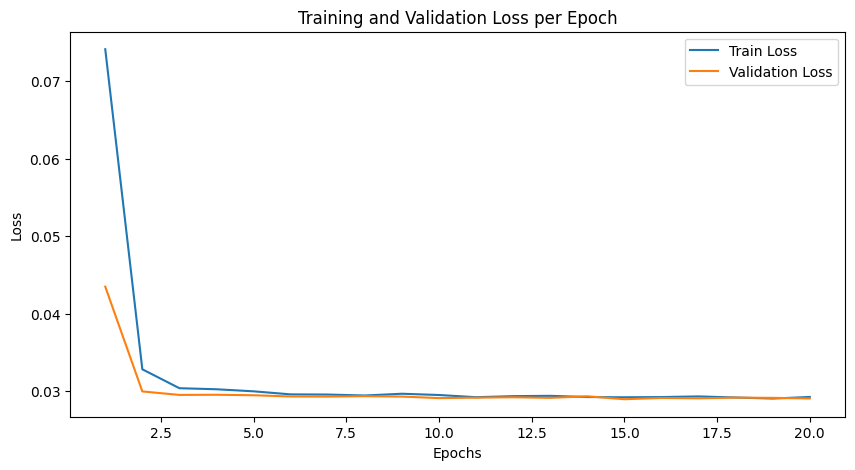

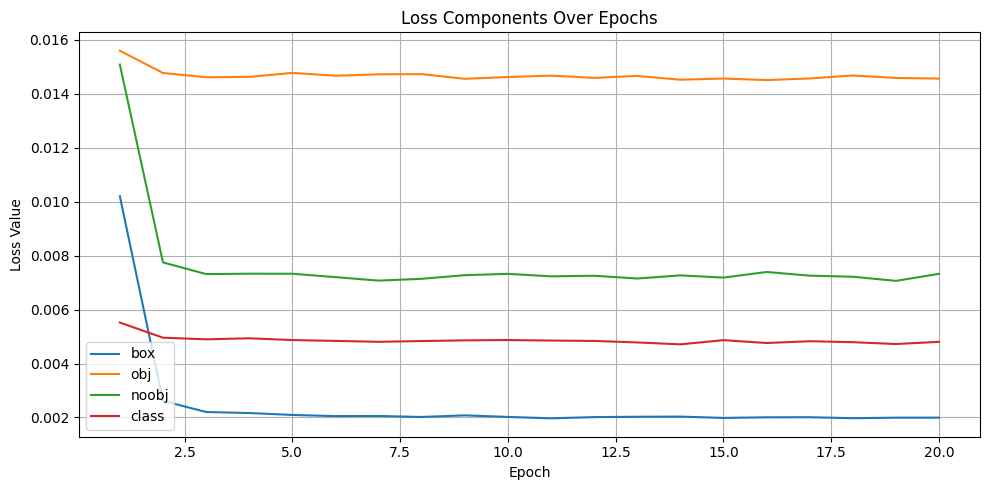

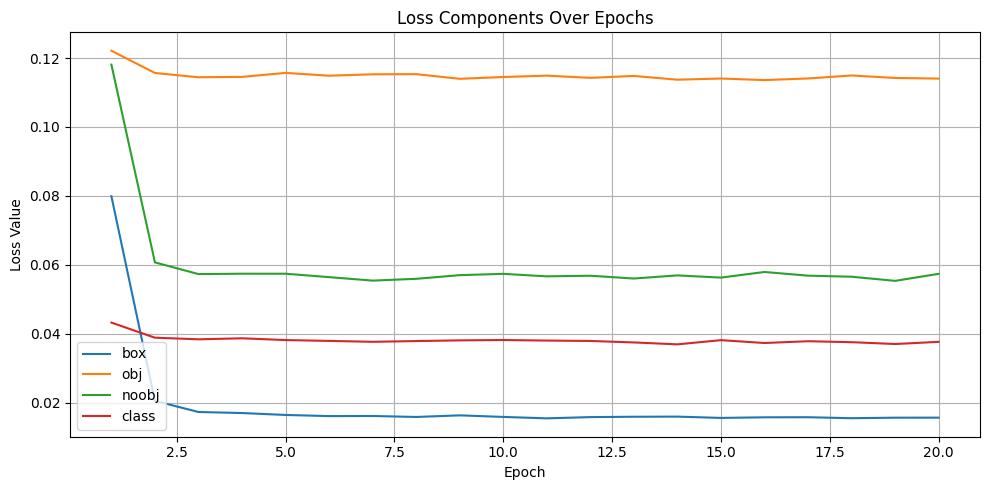

In [ ]:
model = YOLO_like()
print(model)
train_model(model, train_dl, val_dl, epochs=100, lr=0.01, save_path="/yolo_like.pt")

Mean average precision: 0.015043869614601135
Confusion Matrix(thresholds iou=0.4, conf=0):
               cat  dog  no-detection
cat             6   98            14
dog            28  186            36
no-detection    0    0             0




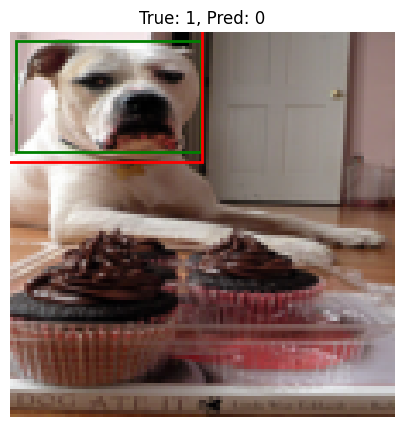

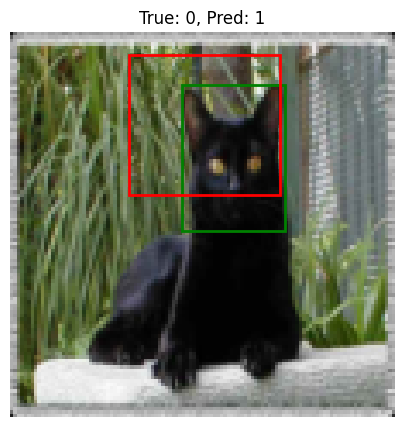

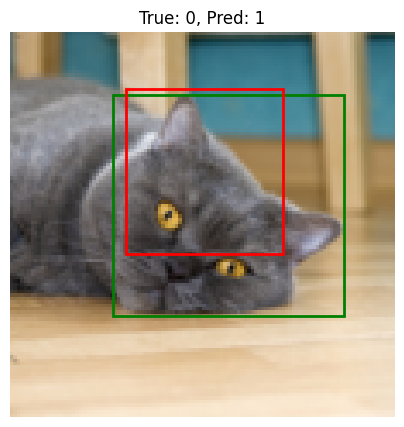

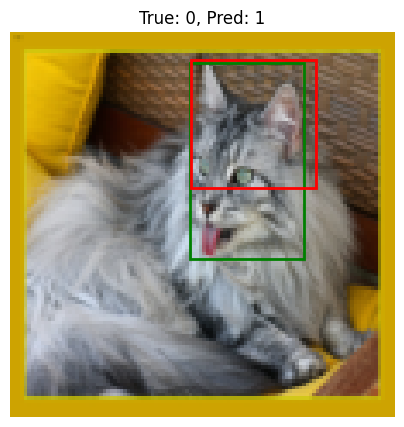

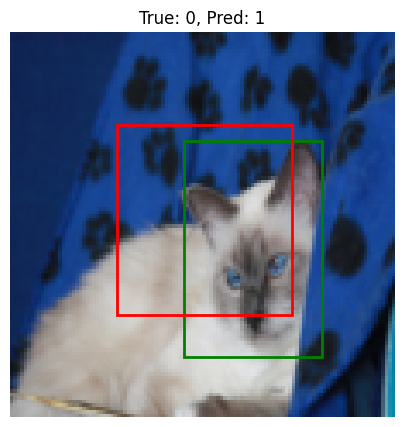

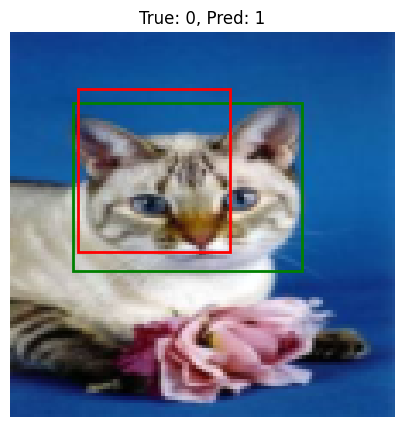

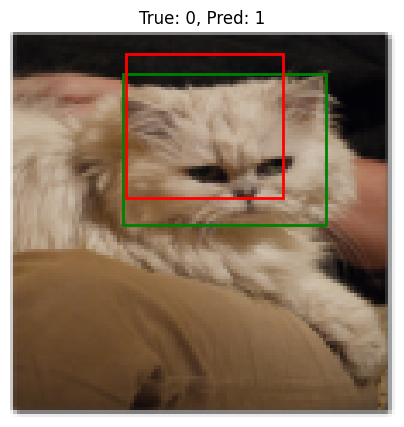

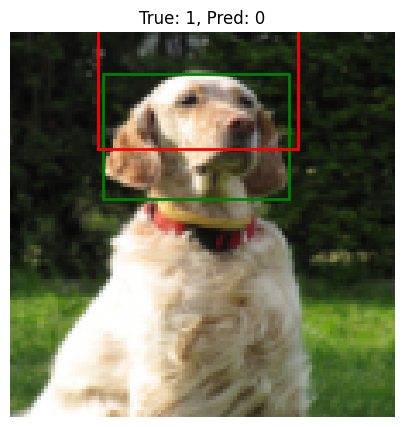

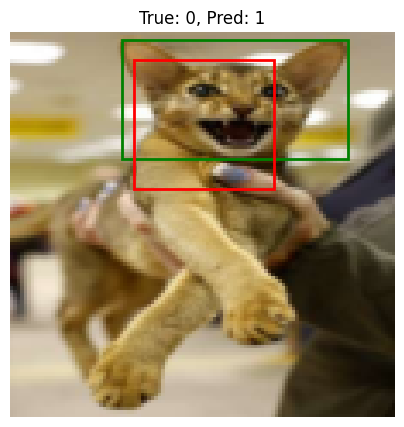

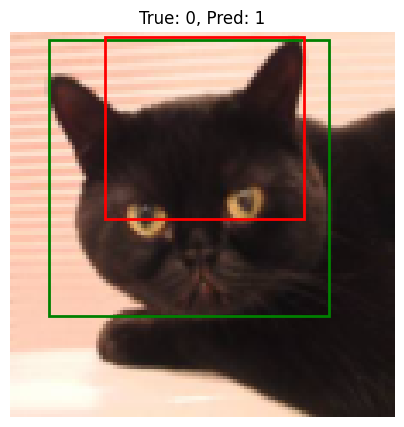

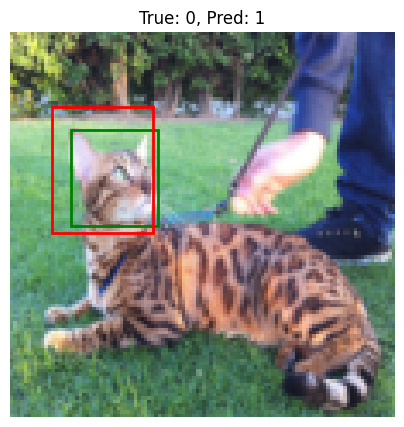

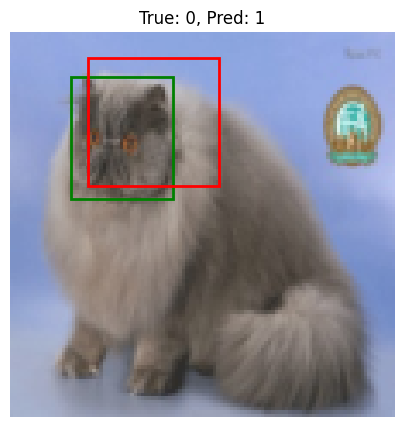

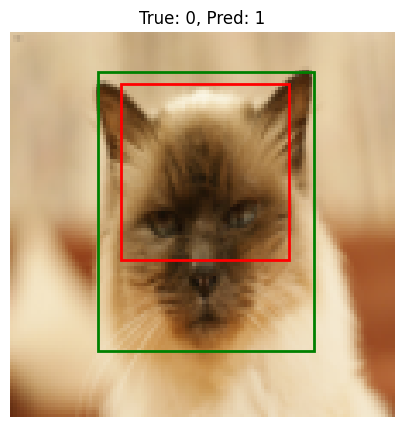

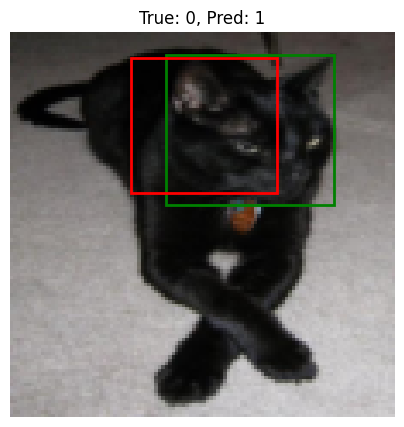

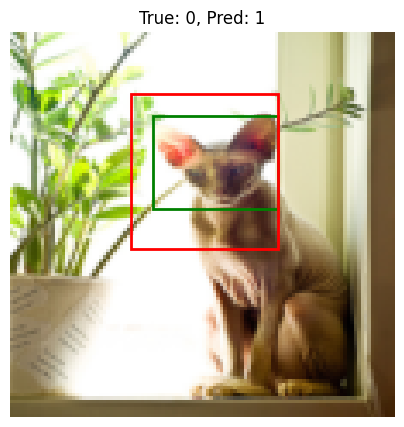

Mean average precision: 0.013930619694292545
Confusion Matrix(thresholds iou=0.4, conf=0.1):
               cat  dog  no-detection
cat             0   85            33
dog             0  189            61
no-detection    0    0             0




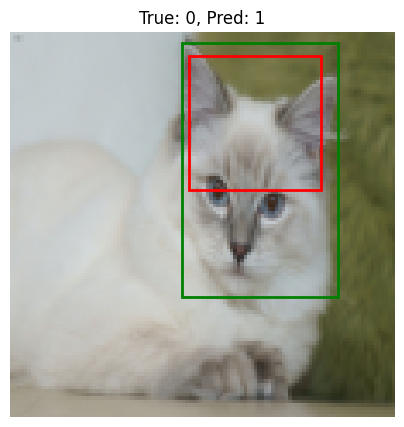

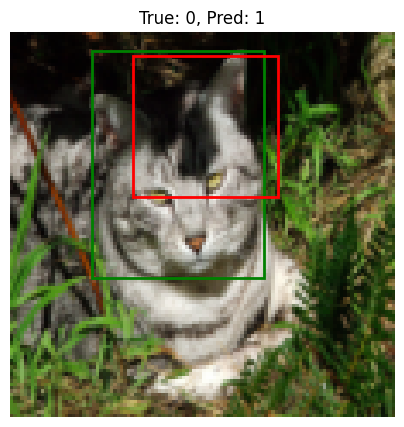

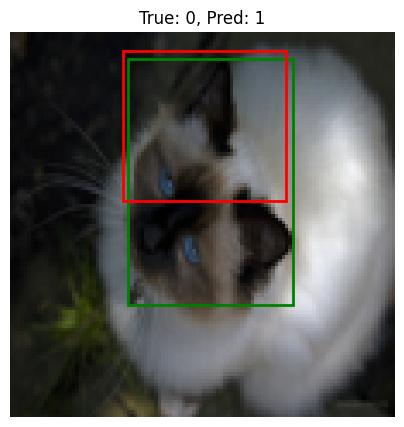

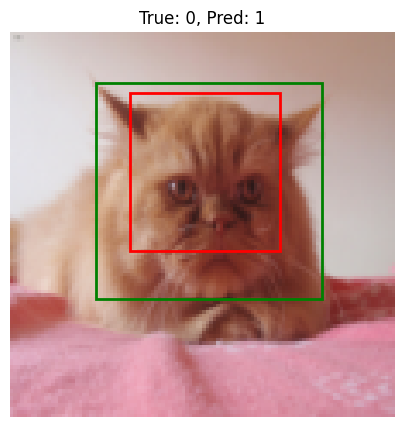

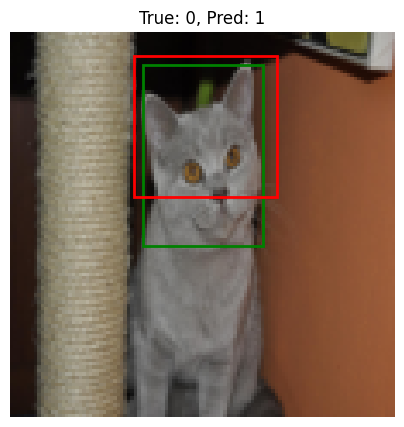

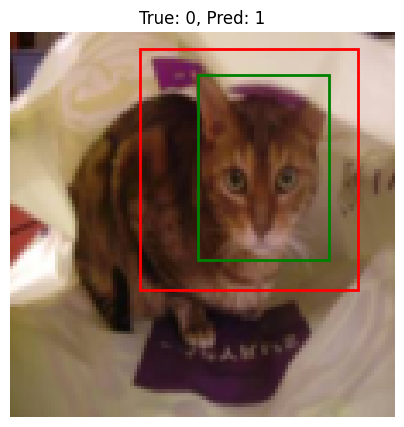

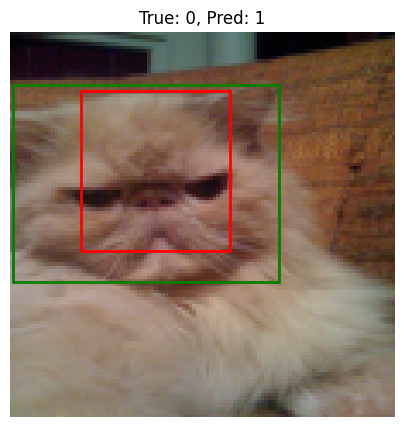

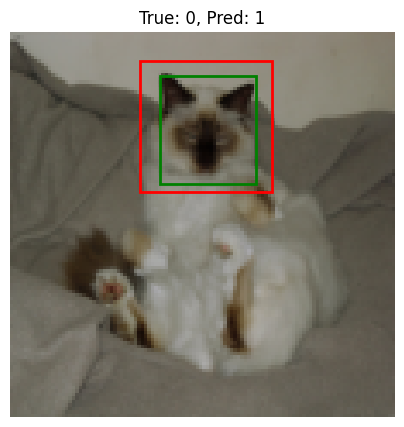

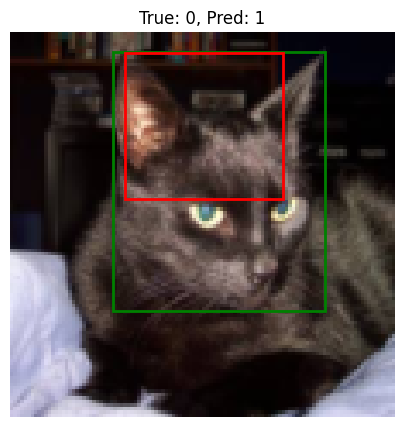

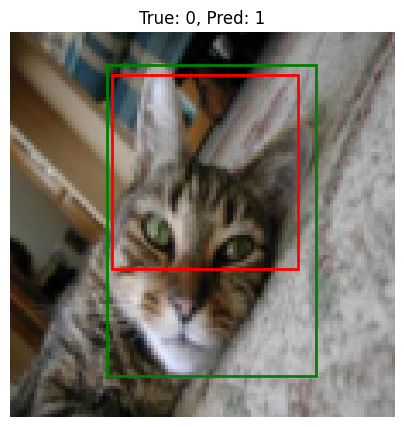

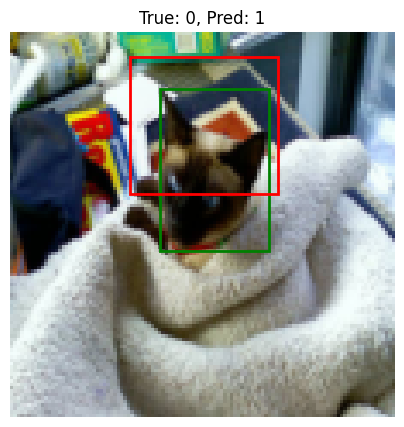

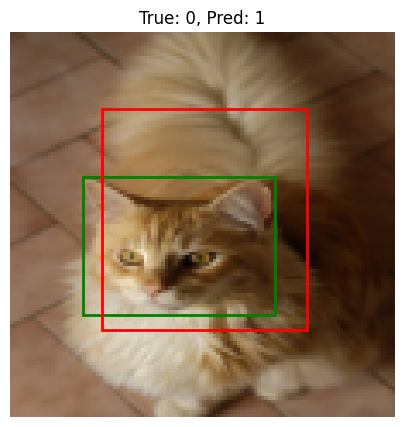

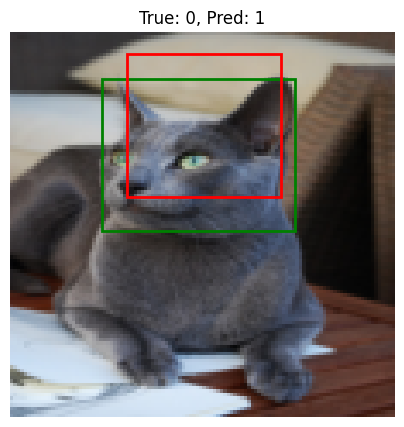

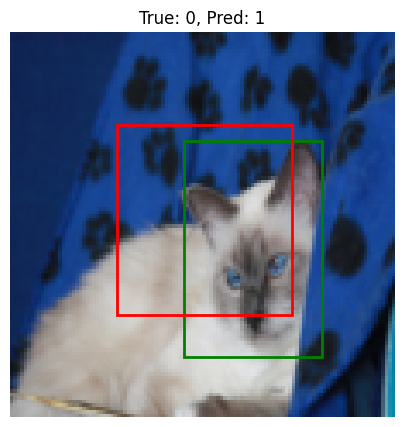

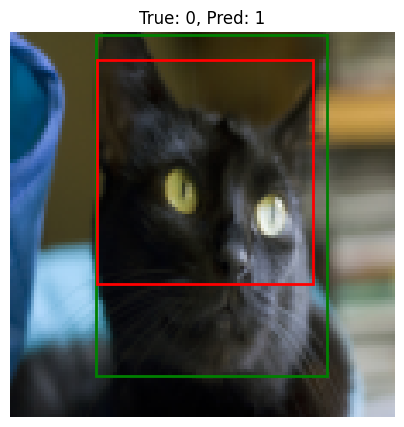

Mean average precision: 0.012423718348145485
Confusion Matrix(thresholds iou=0.4, conf=0.2):
               cat  dog  no-detection
cat             0   65            53
dog             0  165            85
no-detection    0    0             0




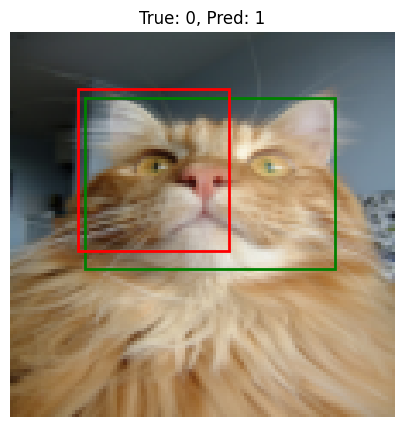

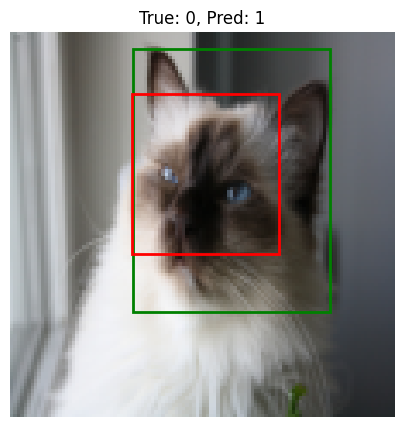

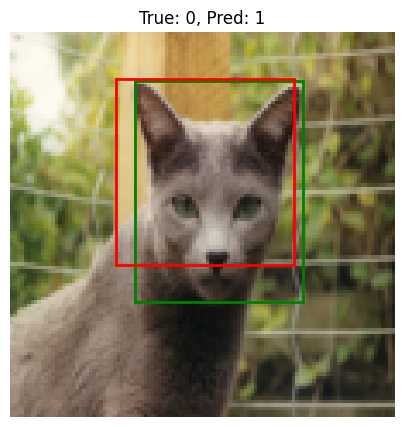

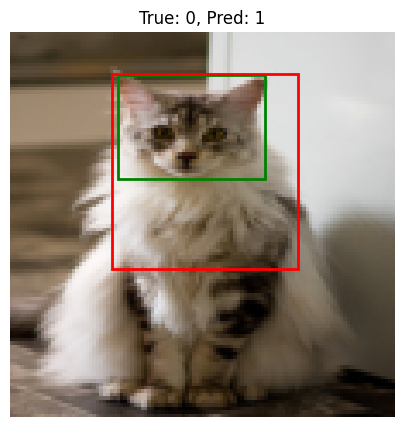

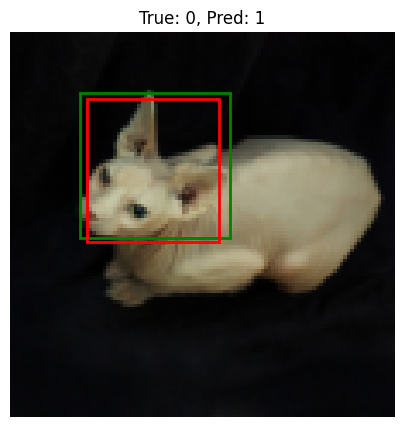

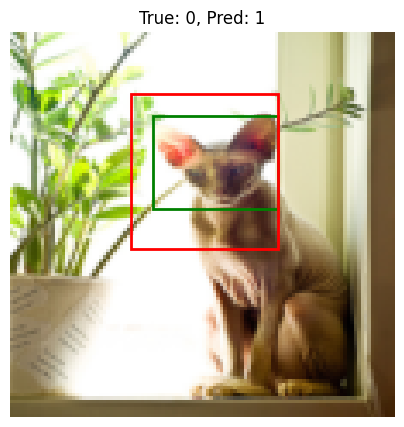

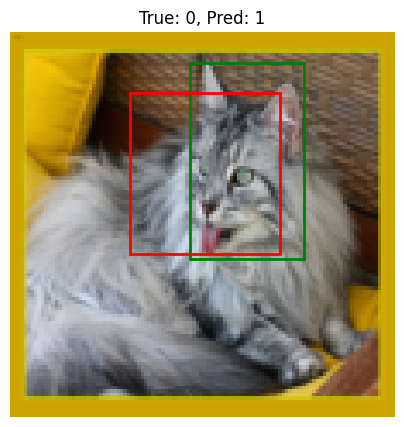

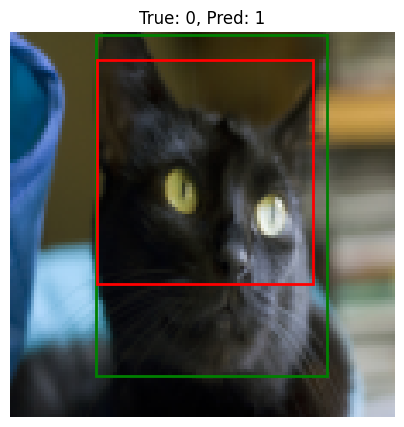

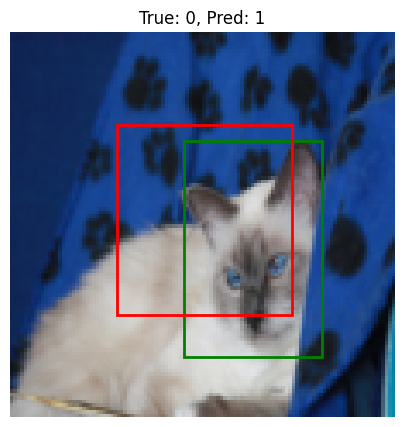

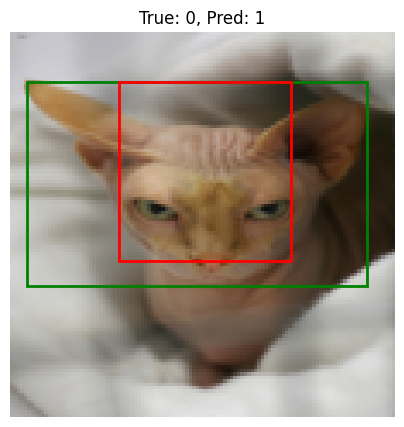

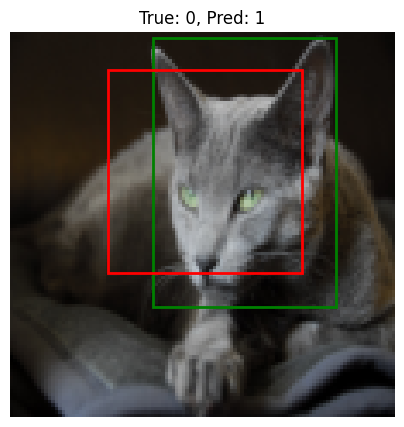

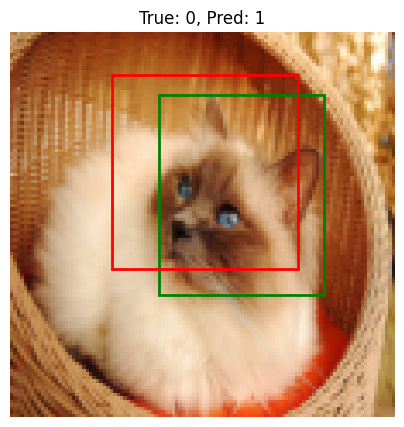

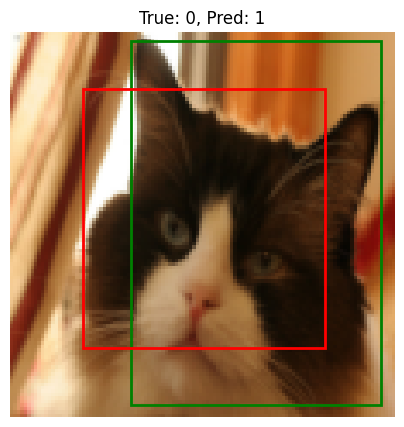

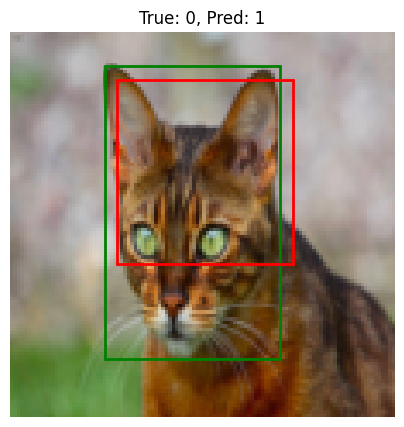

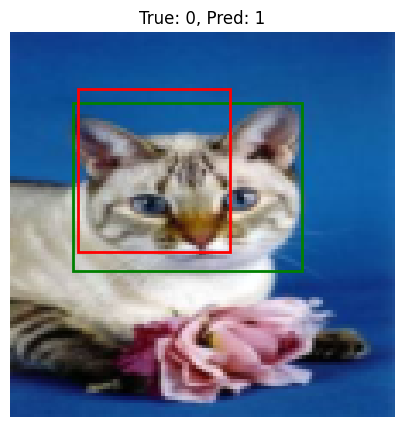

Mean average precision: 0.010123953223228455
Confusion Matrix(thresholds iou=0.4, conf=0.3):
               cat  dog  no-detection
cat             0   58            60
dog             0  128           122
no-detection    0    0             0




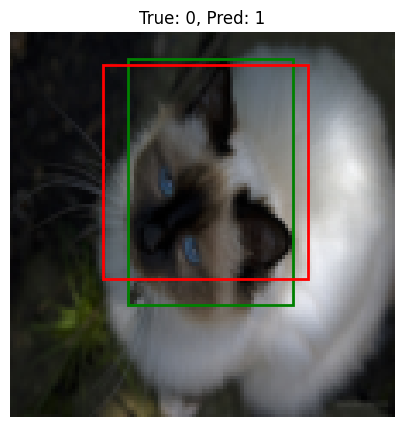

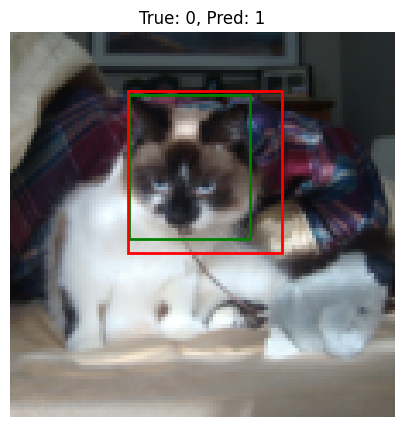

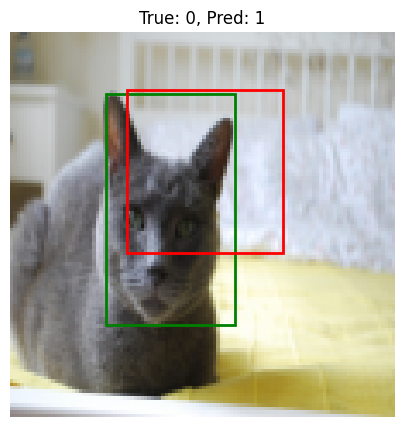

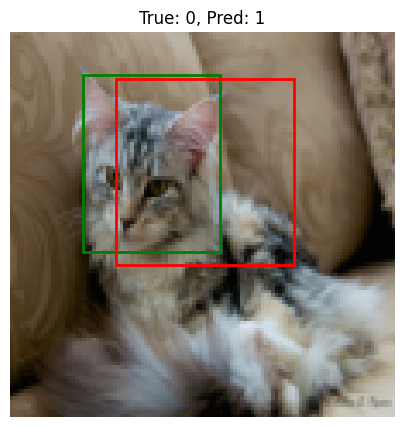

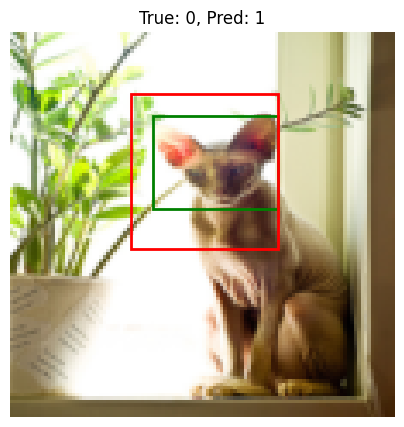

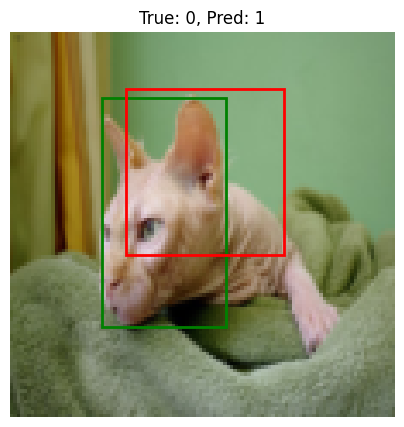

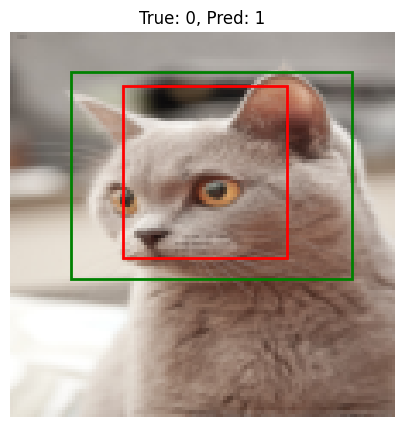

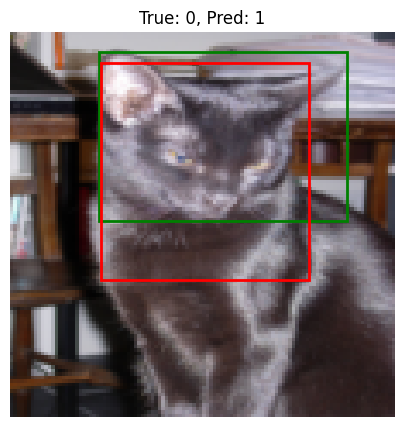

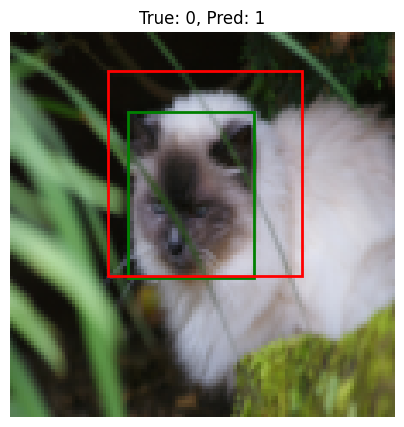

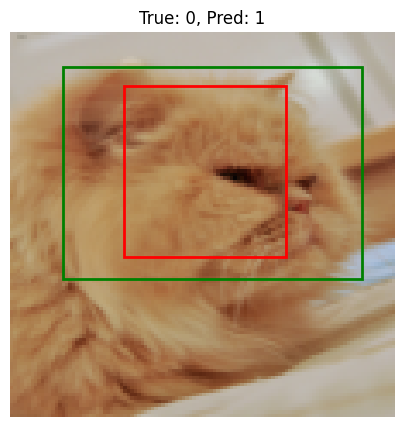

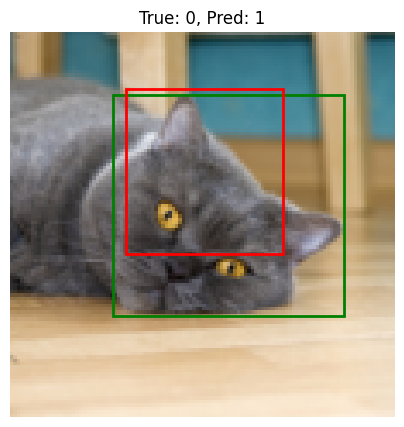

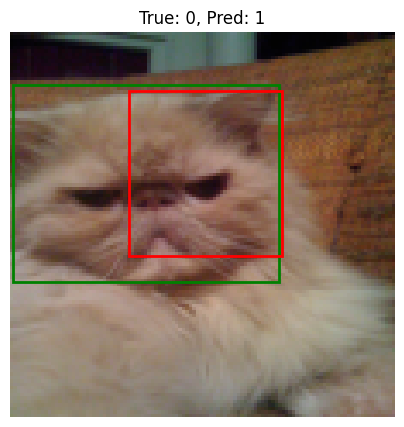

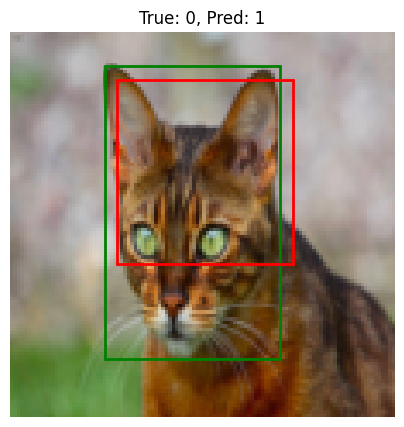

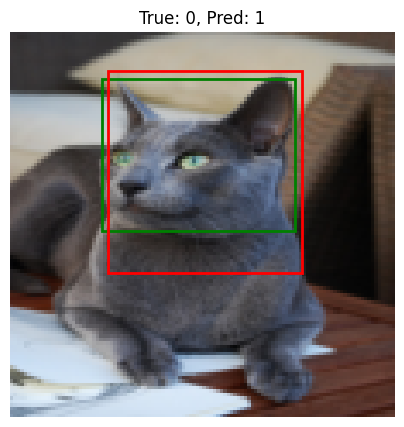

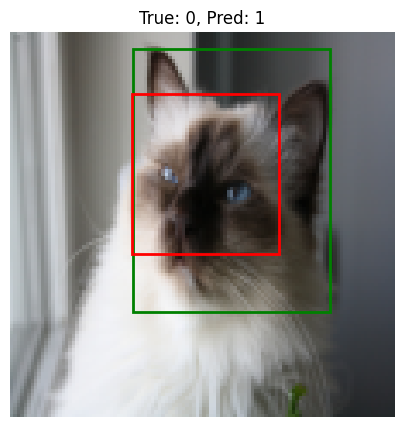

Mean average precision: 0.009862500242888927
Confusion Matrix(thresholds iou=0.4, conf=0.4):
               cat  dog  no-detection
cat             0   57            61
dog             0  127           123
no-detection    0    0             0




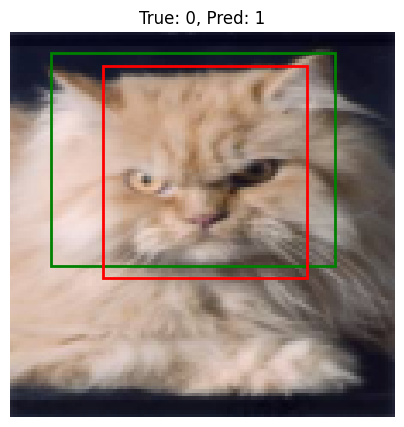

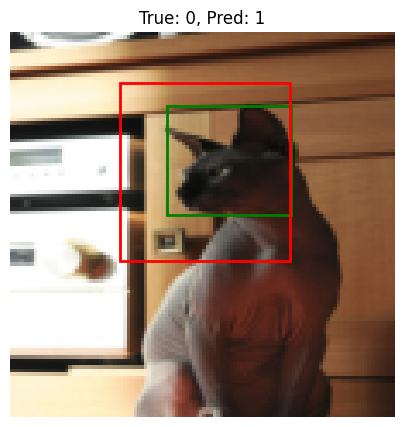

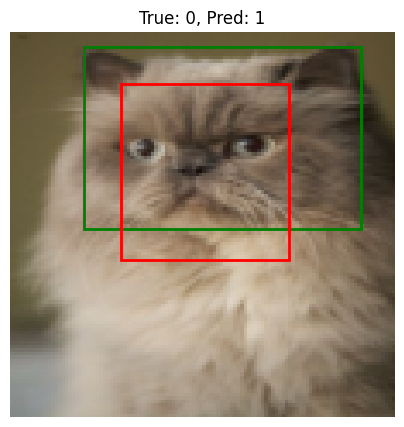

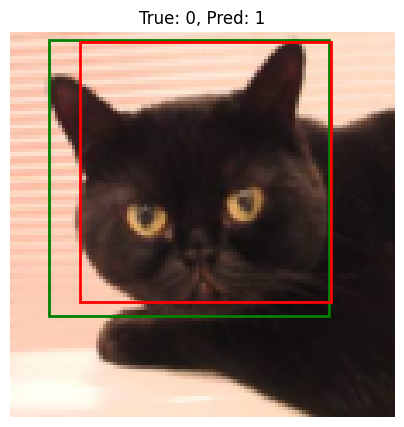

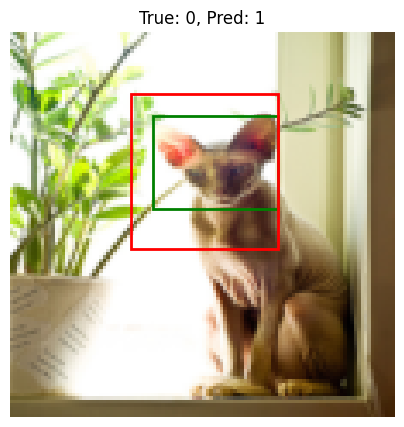

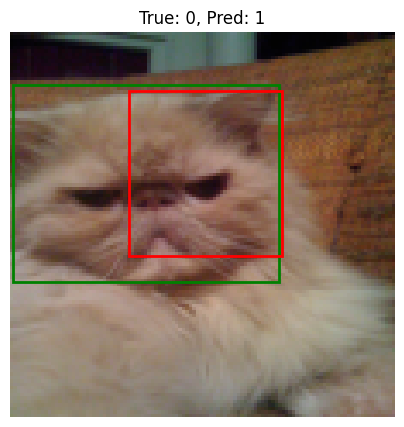

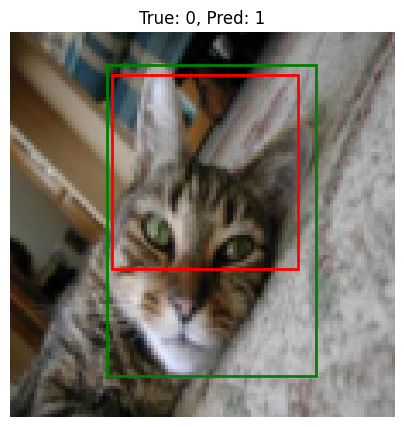

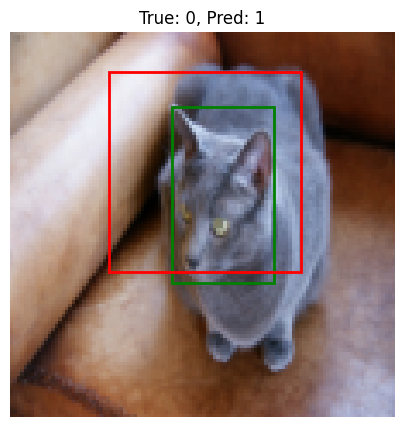

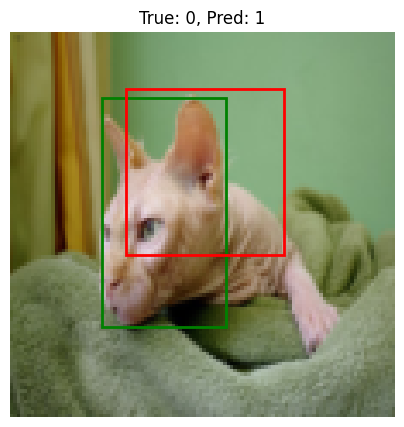

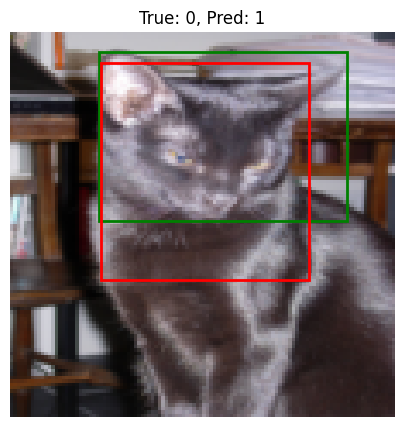

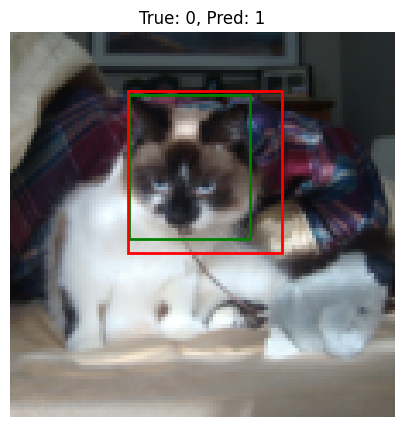

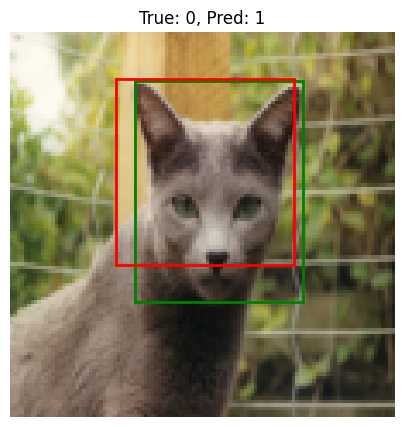

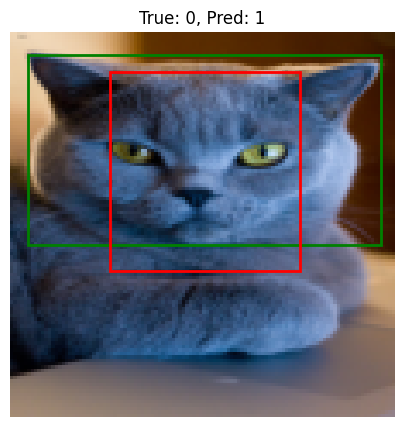

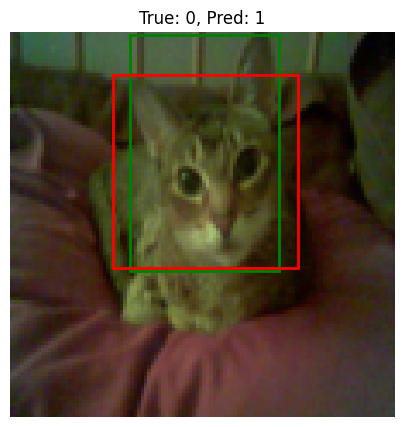

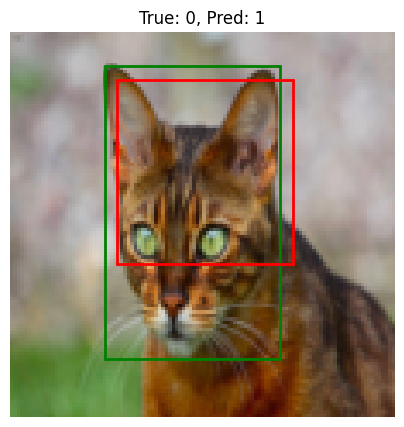

Mean average precision: 0.0006600660271942616
Confusion Matrix(thresholds iou=0.4, conf=0.5):
               cat  dog  no-detection
cat             0    0           118
dog             0    5           245
no-detection    0    0             0


Mean average precision: 0.0
Confusion Matrix(thresholds iou=0.4, conf=0.6):
               cat  dog  no-detection
cat             0    0           118
dog             0    0           250
no-detection    0    0             0


Mean average precision: 0.0
Confusion Matrix(thresholds iou=0.4, conf=0.7):
               cat  dog  no-detection
cat             0    0           118
dog             0    0           250
no-detection    0    0             0


Mean average precision: 0.0
Confusion Matrix(thresholds iou=0.4, conf=0.8):
               cat  dog  no-detection
cat             0    0           118
dog             0    0           250
no-detection    0    0             0


Mean average precision: 0.0
Confusion Matrix(thresholds iou=0.4, conf=0.9)

In [ ]:
conf_thresholds = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
iou = 0.4
map_list = []
for conf in conf_thresholds:
    map = evaluate(model, test_dl, iou=iou, conf=conf, device="cpu")
    map_list.append(map)

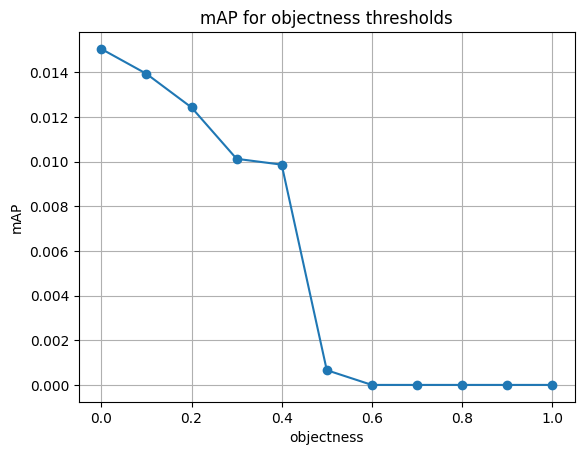

In [ ]:
plt.plot(conf_thresholds, map_list, marker="o")
plt.xlabel("objectness")
plt.ylabel("mAP")
plt.title("mAP for objectness thresholds")
plt.grid(True)
plt.show()

Mean average precision: 0.01902942545711994
Confusion Matrix(thresholds iou=0.4, conf=0):
               cat   dog  no-detection
cat            43   828            85
dog           293  1517           183
no-detection    0     0             0




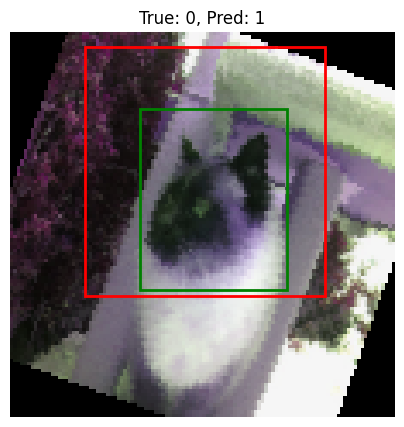

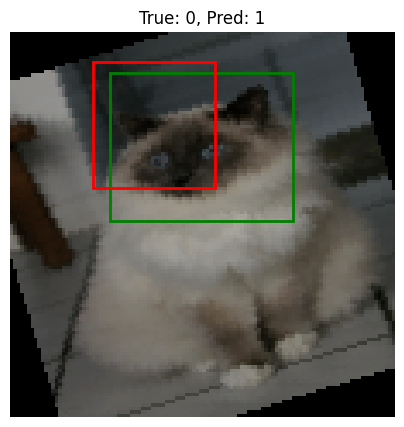

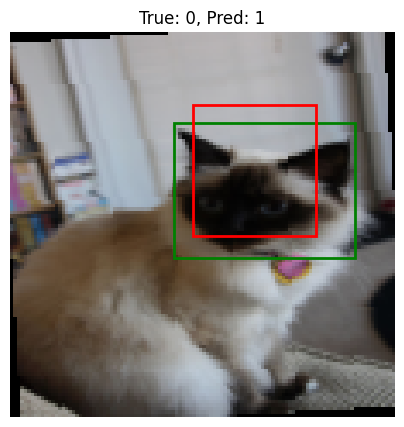

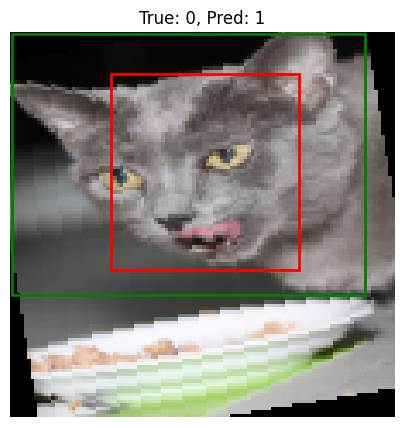

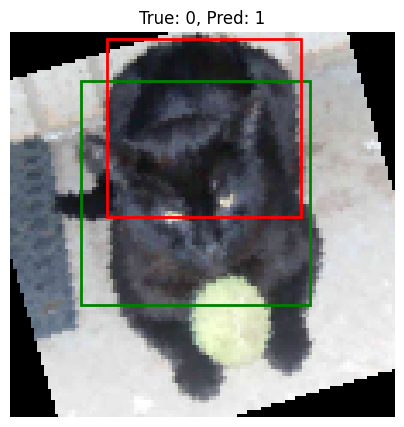

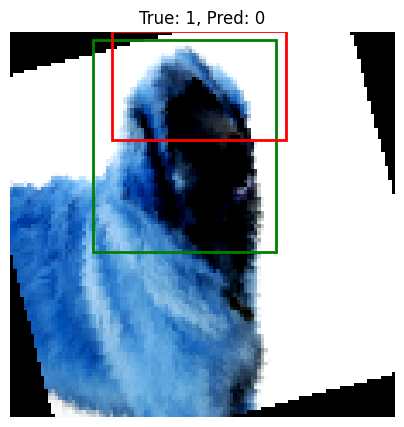

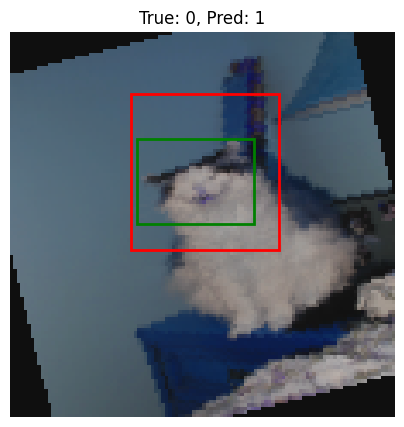

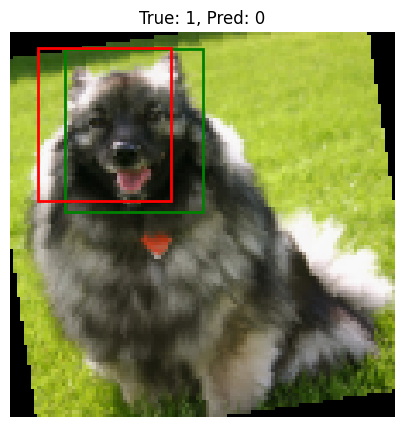

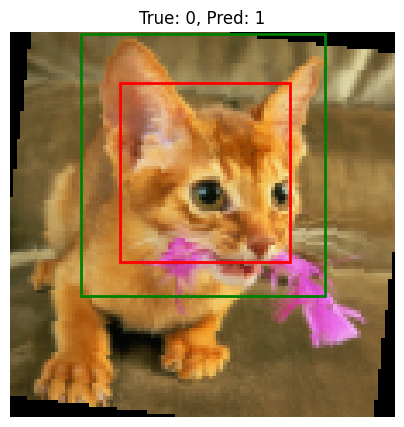

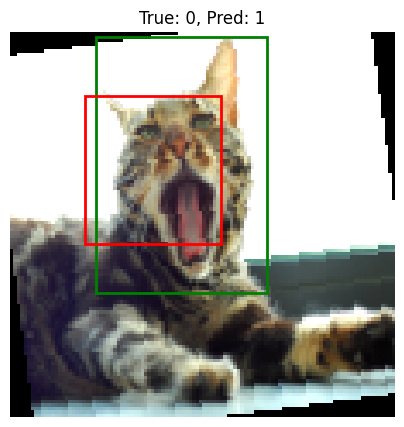

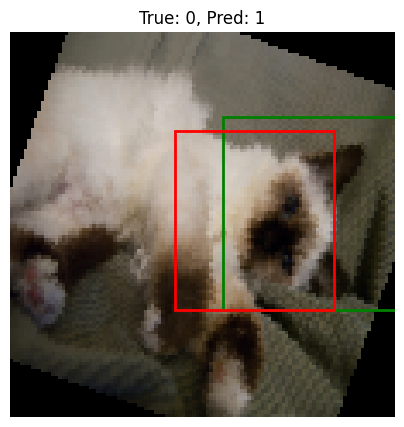

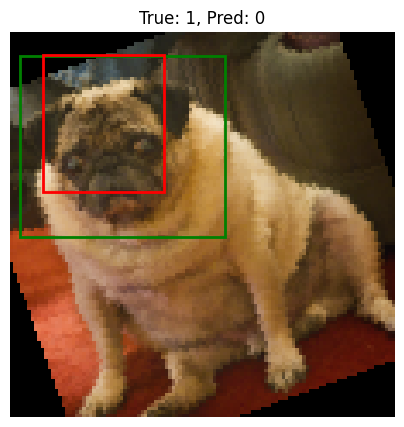

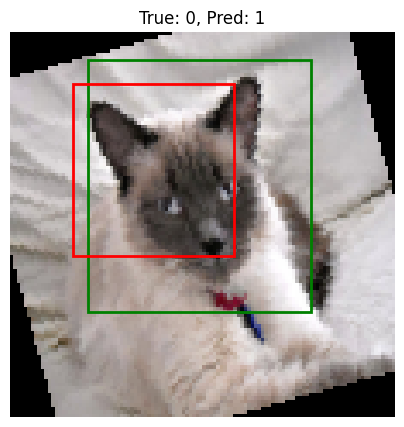

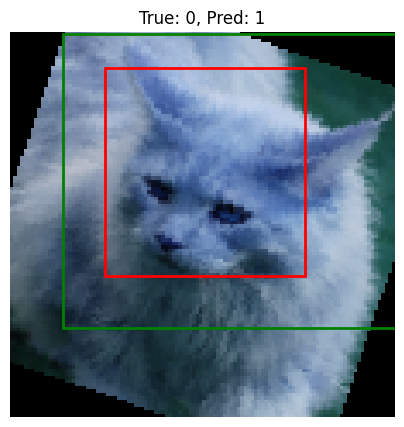

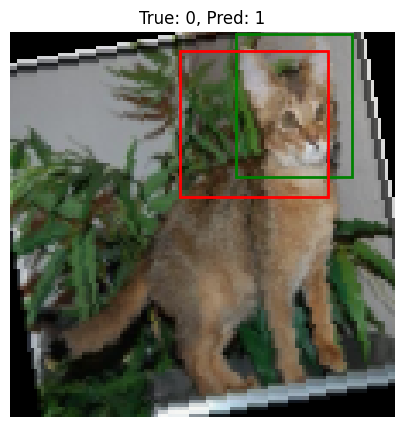

Mean average precision: 0.020042436197400093
Confusion Matrix(thresholds iou=0.4, conf=0):
               cat  dog  no-detection
cat             6   89            19
dog            33  185            37
no-detection    0    0             0




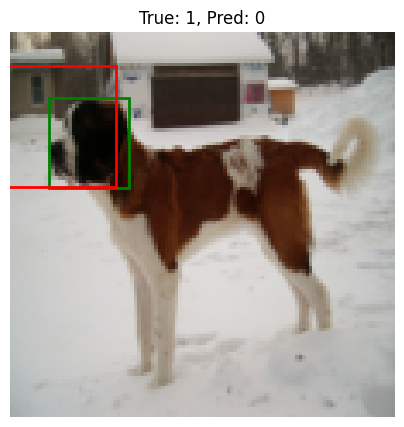

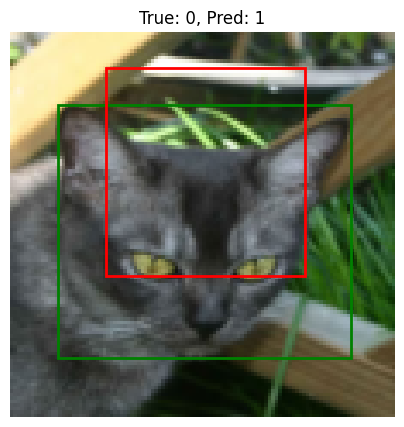

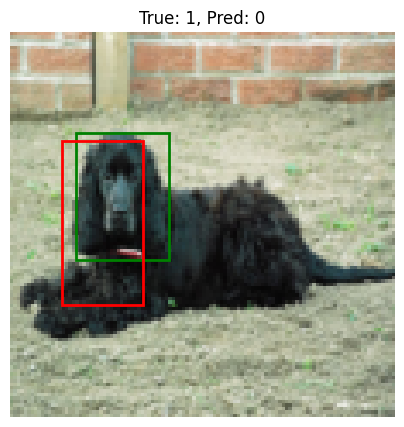

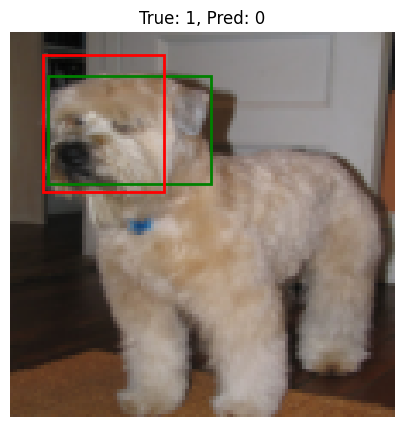

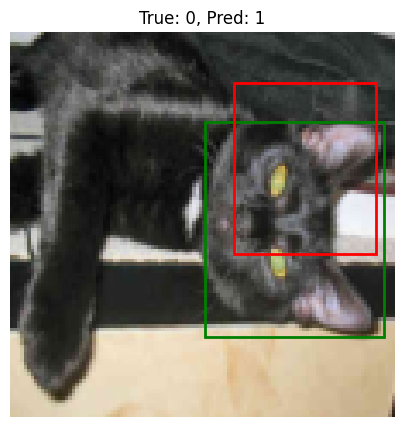

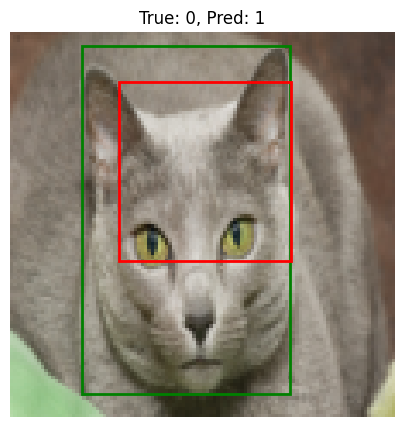

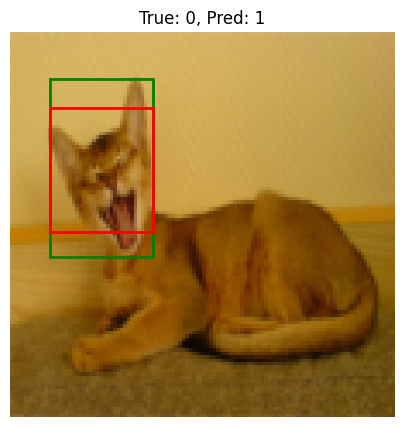

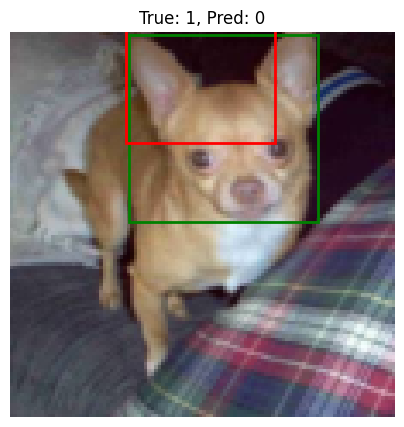

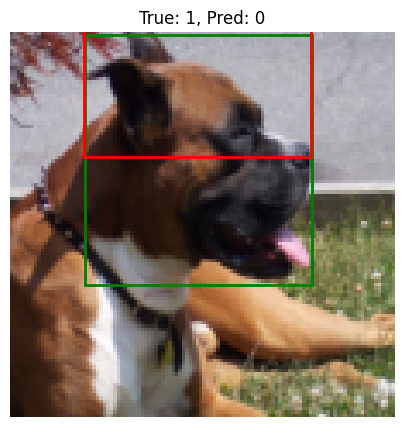

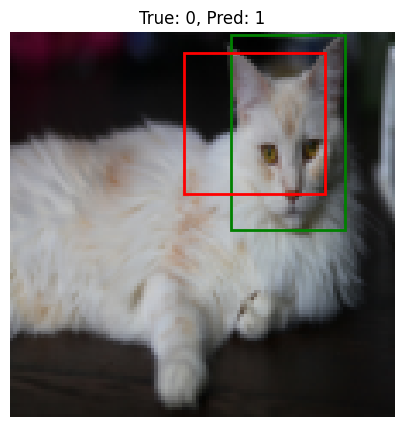

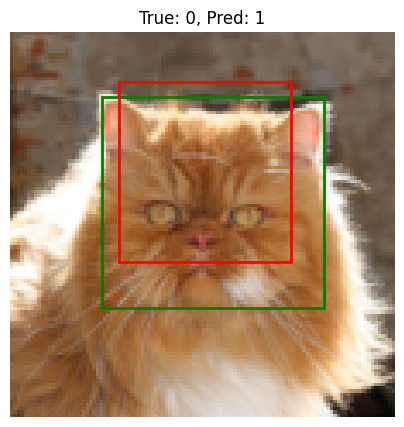

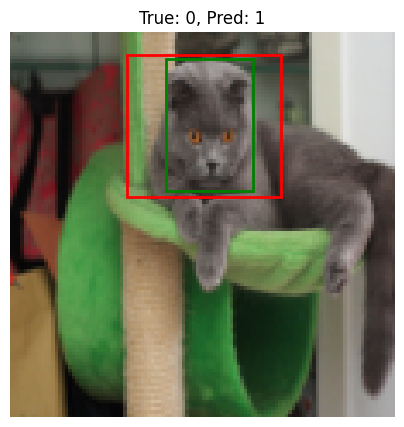

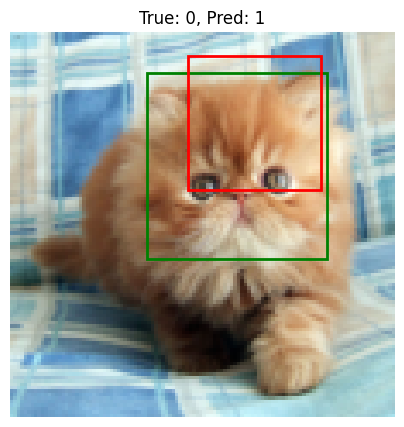

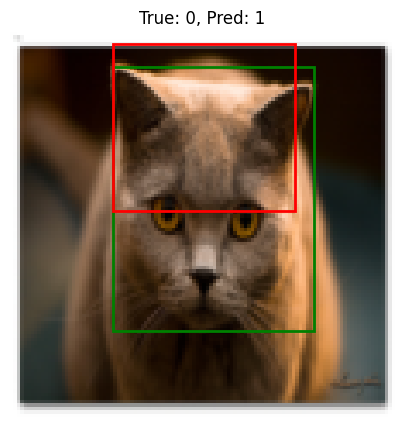

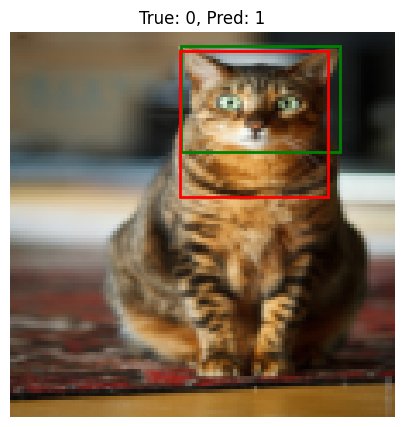

Mean average precision: 0.015043869614601135
Confusion Matrix(thresholds iou=0.4, conf=0):
               cat  dog  no-detection
cat             6   98            14
dog            28  186            36
no-detection    0    0             0




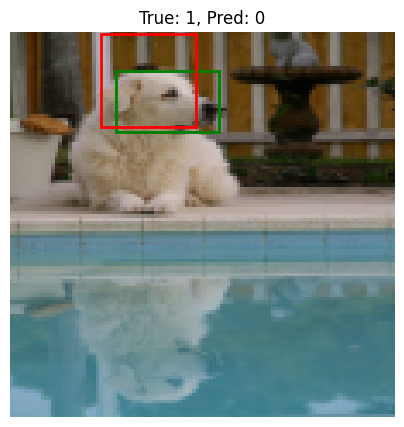

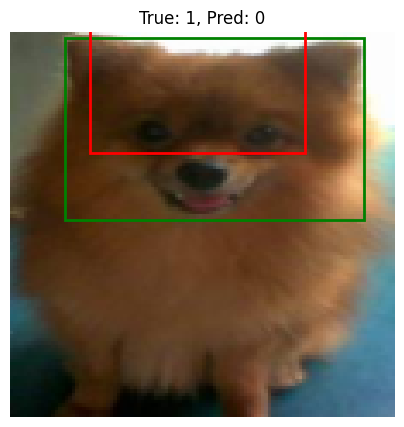

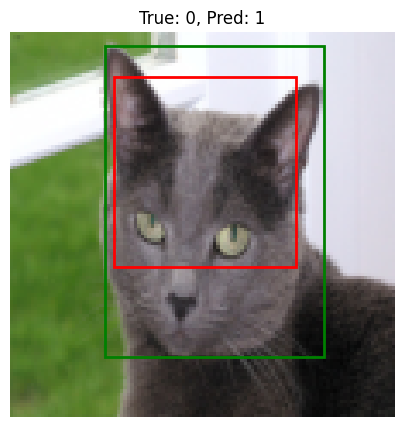

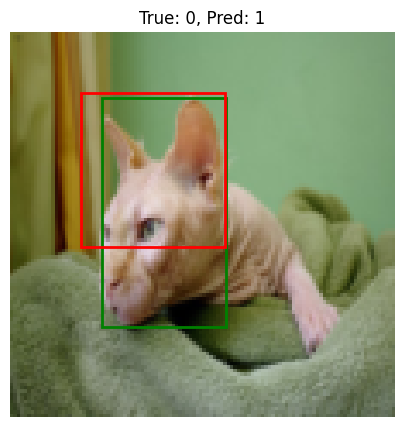

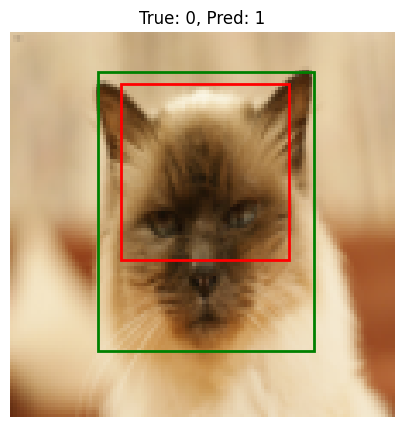

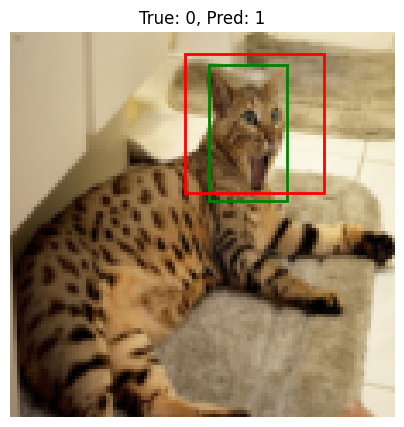

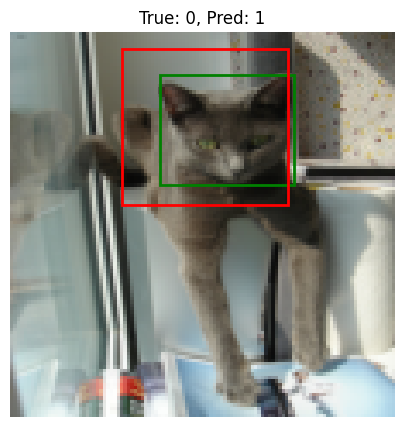

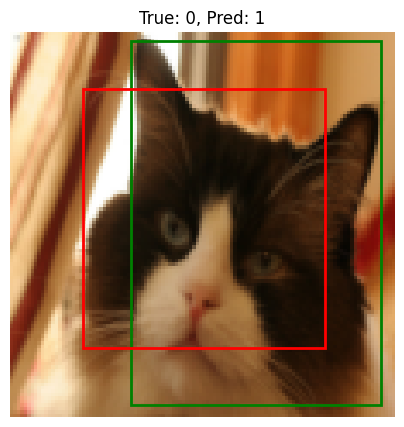

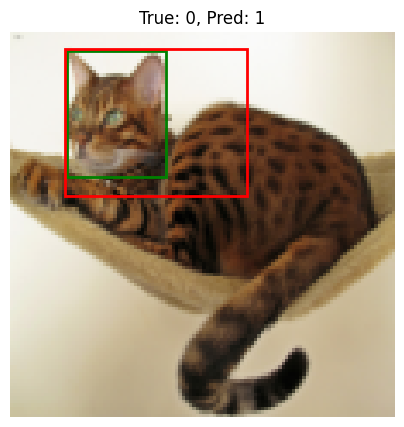

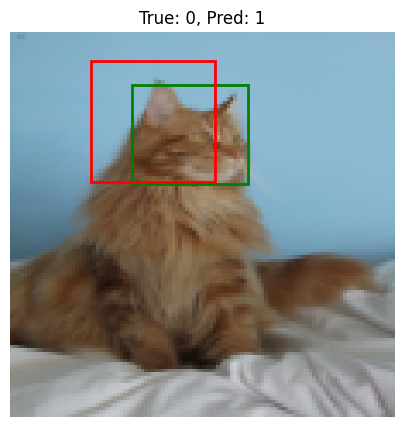

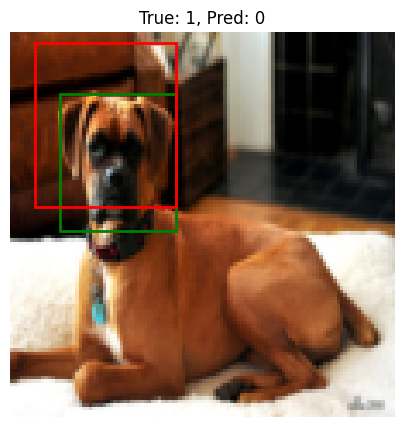

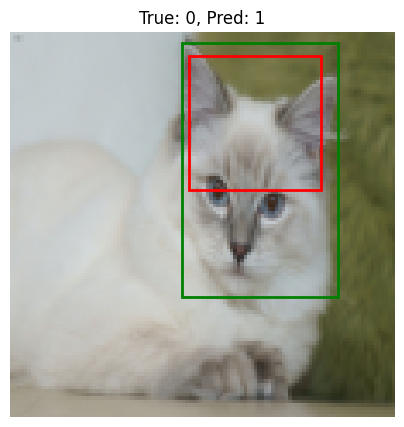

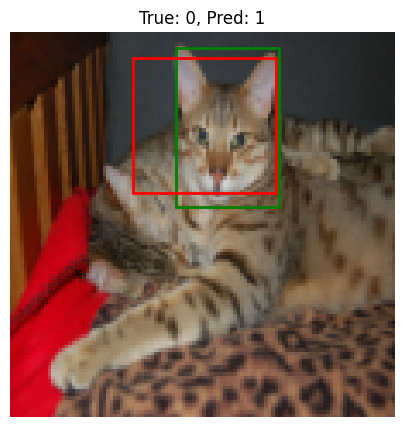

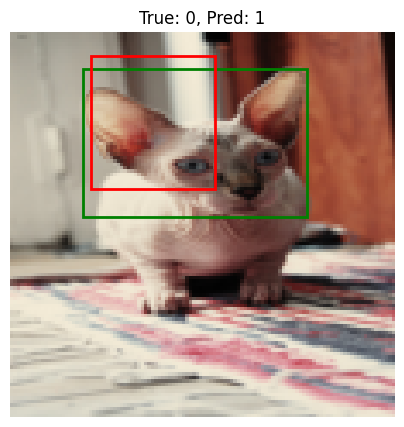

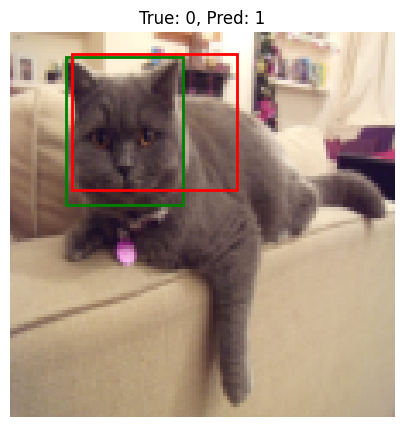

tensor(0.0150)

In [ ]:
evaluate(model, train_dl, conf=0, iou=0.4, device="cpu")
evaluate(model, val_dl, conf=0, iou=0.4, device="cpu")
evaluate(model, test_dl, conf=0, iou=0.4, device="cpu")

---
# **Choice Task 3** (Pretrain Backbone)
---


## Dataset


In [ ]:
# Download latest version
path = kagglehub.dataset_download("bhavikjikadara/dog-and-cat-classification-dataset")
!cp -rf $path ./cat_dog_classification

In [ ]:
transform = T.Compose(
    [
        T.ToImage(),
        T.Resize((112, 112)),
        T.RandomRotation(degrees=20),
        T.RandomHorizontalFlip(p=0.5),
        T.RandomPhotometricDistort(hue=(0, 0), p=0.2),
        T.ToDtype(torch.float32, scale=True),
    ]
)

base_transform = T.Compose(
    [
        T.ToImage(),
        T.Resize((112, 112)),
        T.ToDtype(torch.float32, scale=True),
    ]
)

dataset = ImageFolder(
    root="/content/cat_dog_classification/PetImages", transform=base_transform
)

train_dataset, val_dataset = torch.utils.data.random_split(dataset, [0.8, 0.2])
train_dataset.dataset.transform = transform
train_dataloader = DataLoader(
    train_dataset, batch_size=128, shuffle=True, collate_fn=lambda x: tuple(zip(*x))
)
val_dataloader = DataLoader(
    val_dataset, batch_size=128, shuffle=True, collate_fn=lambda x: tuple(zip(*x))
)

## Backbone


In [ ]:
class BackboneYOLO(YOLO_like):
    def __init__(self, num_classes=2):
        super().__init__()
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        return super().forward(x)

In [ ]:
def train_clf(
    model,
    train_dataloader,
    val_dataloader,
    epochs=30,
    lr=0.001,
    save_path="/backbone_pretrained.pt",
):
    """
    function that implements training and saves model weights

    model: CNN model to be trained
    train_dataloader: training set dataloader
    val_dataloader: validation set dataloader
    epochs: max numr of epochs
    save_path: path to save model weights
    """
    # if gpu is available use gpu during training
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # CE Loss , Adam optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    # lists to store loss, accuracy and learning rate values
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    # lr_history = [] # add lr function

    for epoch in range(epochs):
        model.train()
        train_loss, val_loss = 0, 0
        train_correct, val_correct = 0, 0
        # optimizer = lr_scheduler(optimizer, epoch)
        # lr_history.append(optimizer.param_groups[0]['lr'])

        for batch, labels in train_dataloader:  # check

            batch = torch.stack(batch).to(device)
            labels = torch.tensor(labels).to(device)
            optimizer.zero_grad()
            output = model(batch)  # pass through model
            # batch loss
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            # add to epoch loss
            train_loss += loss.item()
            # accuracy calculation
            _, predicted = torch.max(output, 1)
            train_correct += (predicted == labels).sum().item()

        # validation performance
        model.eval()
        with torch.no_grad():
            for batch, labels in val_dataloader:
                batch = torch.stack(batch).to(device)
                labels = torch.tensor(labels).to(device)
                output = model(batch)
                # batch loss
                loss = criterion(output, labels)
                val_loss += loss.item()
                # accuracy calculation
                _, predicted = torch.max(output, 1)
                val_correct += (predicted == labels).sum().item()

        # train, val loss, accuracy here
        train_acc = 100 * train_correct / len(train_dataloader.dataset)
        val_acc = 100 * val_correct / len(val_dataloader.dataset)

        train_epoch_loss = train_loss / len(train_dataloader)
        val_epoch_loss = val_loss / len(val_dataloader)

        print(
            f"Epoch {epoch+1}/{epochs}, Train Loss:{train_epoch_loss:.4f}, Train Accuracy:{train_acc:.2f}%, Val Loss:{val_epoch_loss:.4f}, Val Acc:{val_acc:.2f}%"
        )
        # append epoch metrics to lists
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        train_losses.append(train_epoch_loss)
        val_losses.append(val_epoch_loss)

        # early stopping
        if (
            val_epoch_loss >= min(val_losses)
            and epoch - np.argmin(np.array(val_losses)) >= 3
        ):
            torch.save(model.state_dict(), save_path)
            print(f"Model weights saved at {save_path}\n")
            break

    # print(f"top-1 training accuracy: {max(train_accuracies)}")
    # print(f"top-1 validation accuracy: {max(val_accuracies)}\n")
    plot_loss(train_losses, val_losses)

    return

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 1/30, Train Loss:0.6192, Train Accuracy:65.93%, Val Loss:0.5956, Val Acc:66.49%
Epoch 2/30, Train Loss:0.5554, Train Accuracy:71.35%, Val Loss:0.5408, Val Acc:71.89%
Epoch 3/30, Train Loss:0.5000, Train Accuracy:75.40%, Val Loss:0.4895, Val Acc:74.99%
Epoch 4/30, Train Loss:0.4392, Train Accuracy:79.34%, Val Loss:0.4141, Val Acc:81.12%
Epoch 5/30, Train Loss:0.3822, Train Accuracy:82.72%, Val Loss:0.3823, Val Acc:82.24%
Epoch 6/30, Train Loss:0.3344, Train Accuracy:85.40%, Val Loss:0.3278, Val Acc:85.82%
Epoch 7/30, Train Loss:0.2925, Train Accuracy:87.28%, Val Loss:0.3500, Val Acc:84.20%
Epoch 8/30, Train Loss:0.2752, Train Accuracy:88.13%, Val Loss:0.2599, Val Acc:88.78%
Epoch 9/30, Train Loss:0.2515, Train Accuracy:89.37%, Val Loss:0.3056, Val Acc:87.00%
Epoch 10/30, Train Loss:0.2312, Train Accuracy:90.24%, Val Loss:0.2614, Val Acc:88.70%
Epoch 11/30, Train Loss:0.2180, Train Accuracy:90.99%, Val Loss:0.2866, Val Acc:87.50%
Model weights saved at /backbone_pretrained.pt



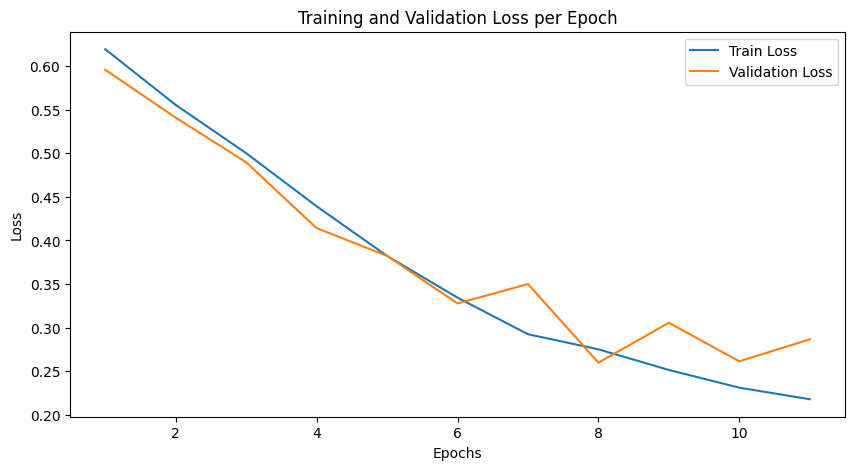

In [ ]:
model = BackboneYOLO()
train_clf(
    model,
    train_dataloader,
    val_dataloader,
    epochs=30,
    lr=0.001,
    save_path="/backbone_pretrained.pt",
)

In [ ]:
model_pretrained = YOLO_like(output=2)
model_pretrained.load_state_dict(
    torch.load("/backbone_pretrained.pt", weights_only=True)
)
# replace last layer and initialize weights
model_pretrained.fc2 = nn.Linear(512, 343)
torch.nn.init.kaiming_normal_(model_pretrained.fc2.weight)
torch.nn.init.kaiming_normal_(model_pretrained.fc1.weight)
print(model_pretrained)

# train_model(model_pretrained, train_dl, val_dl, epochs=20)

YOLO_like(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): AvgPool2d(kernel_size=(2, 2), stride=2, padding=0)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (drop): Dropout(p=0.2, inplace=False)
  (fc1): Linear(

Epoch 1/30: Train Loss:0.1997, Val Loss:0.0537
Epoch 2/30: Train Loss:0.0462, Val Loss:0.0401
Epoch 3/30: Train Loss:0.0372, Val Loss:0.0327
Epoch 4/30: Train Loss:0.0319, Val Loss:0.0302
Epoch 5/30: Train Loss:0.0300, Val Loss:0.0294
Learning rate decreased
Epoch 6/30: Train Loss:0.0286, Val Loss:0.0279
Epoch 7/30: Train Loss:0.0279, Val Loss:0.0270
Epoch 8/30: Train Loss:0.0270, Val Loss:0.0264
Epoch 9/30: Train Loss:0.0265, Val Loss:0.0254
Epoch 10/30: Train Loss:0.0253, Val Loss:0.0246
Learning rate decreased
Epoch 11/30: Train Loss:0.0247, Val Loss:0.0243
Epoch 12/30: Train Loss:0.0249, Val Loss:0.0240
Epoch 13/30: Train Loss:0.0237, Val Loss:0.0236
Epoch 14/30: Train Loss:0.0236, Val Loss:0.0232
Epoch 15/30: Train Loss:0.0231, Val Loss:0.0230
Learning rate decreased
Epoch 16/30: Train Loss:0.0231, Val Loss:0.0228
Epoch 17/30: Train Loss:0.0224, Val Loss:0.0225
Epoch 18/30: Train Loss:0.0229, Val Loss:0.0224
Epoch 19/30: Train Loss:0.0223, Val Loss:0.0225
Epoch 20/30: Train Loss:0

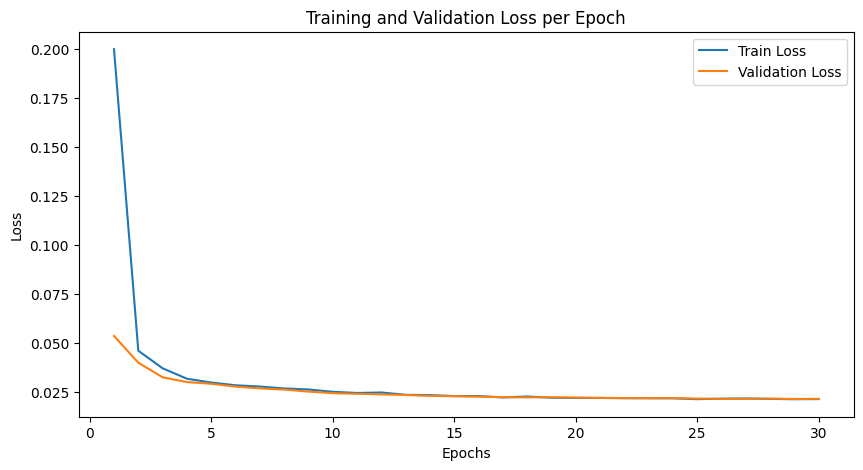

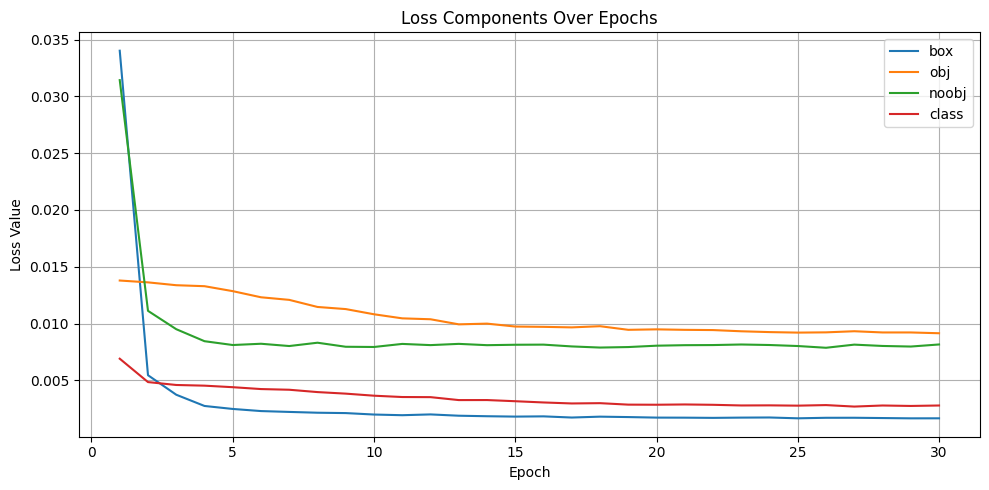

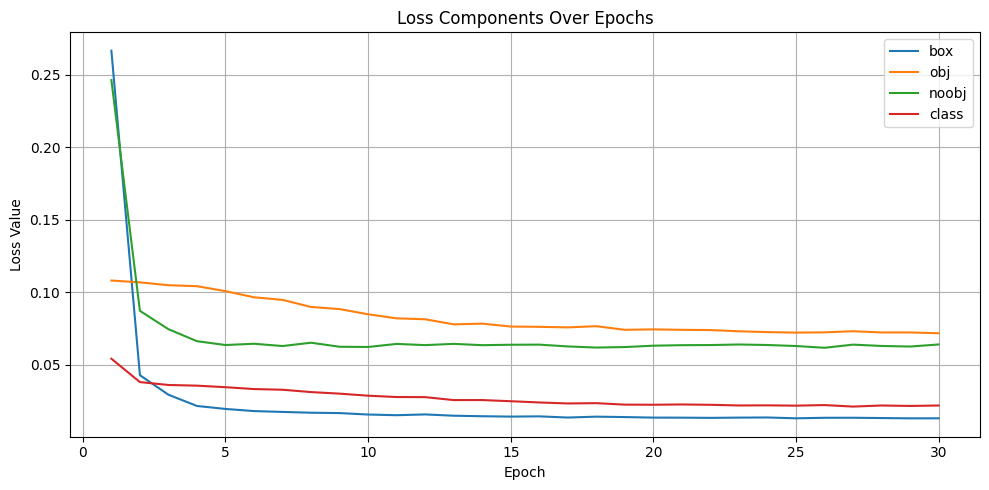

In [ ]:
train_model(
    model_pretrained,
    train_dl,
    val_dl,
    epochs=30,
    lr=0.001,
    save_path="/yolo_pretrained.pt",
)

Mean average precision: 0.07870780676603317
Confusion Matrix(thresholds iou=0.4, conf=0):
               cat  dog  no-detection
cat            42   58            18
dog            43  171            36
no-detection    0    0             0




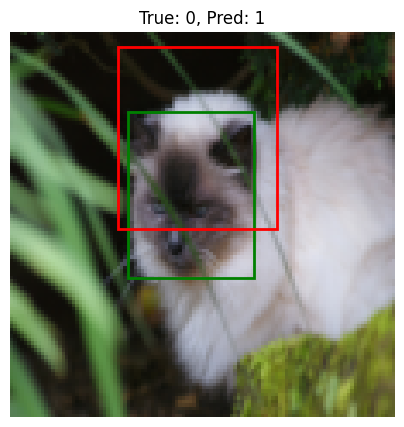

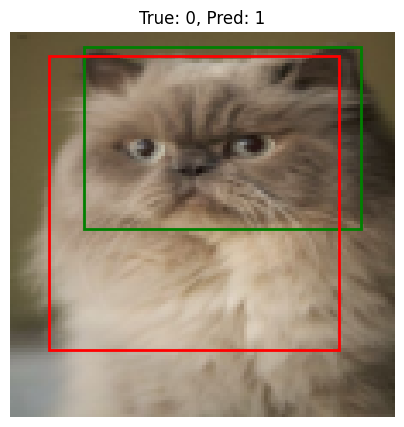

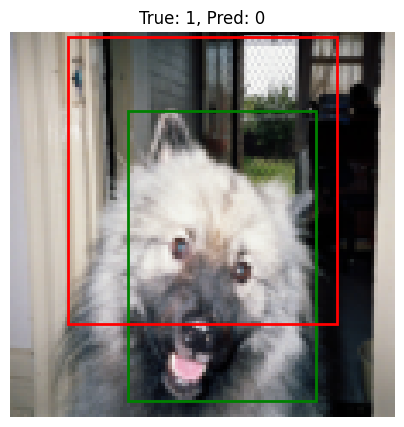

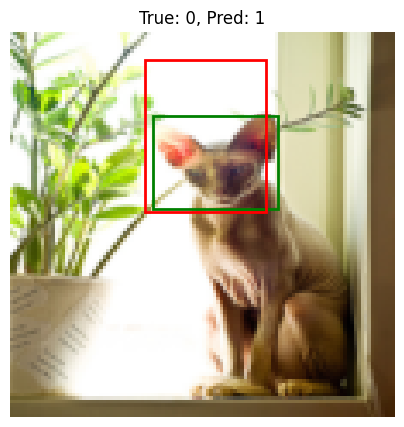

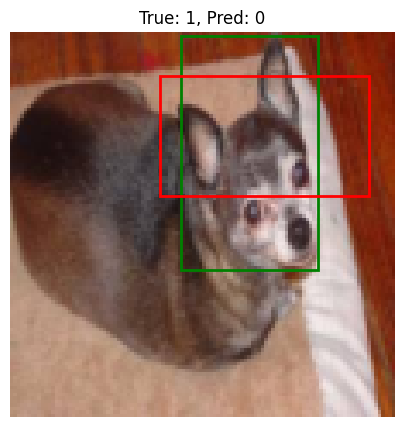

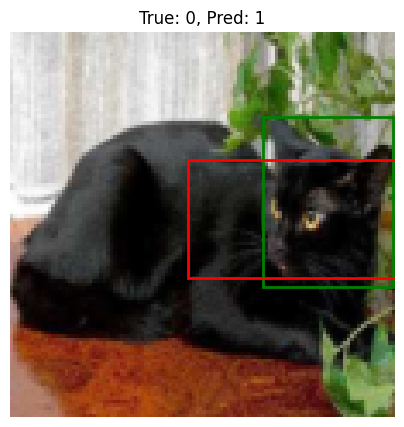

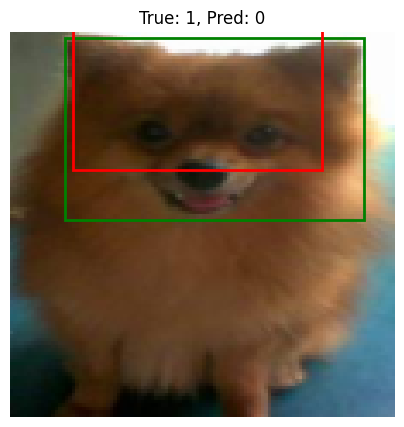

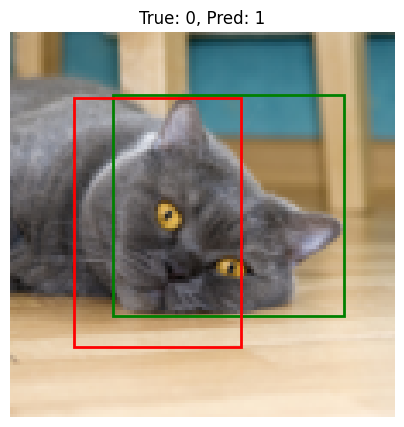

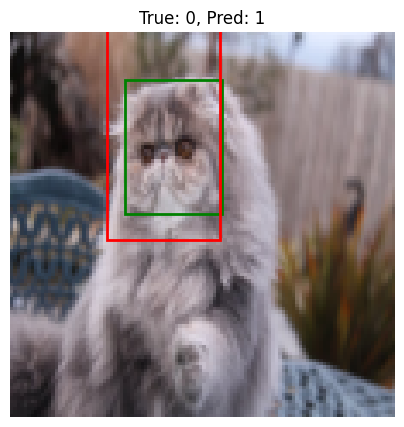

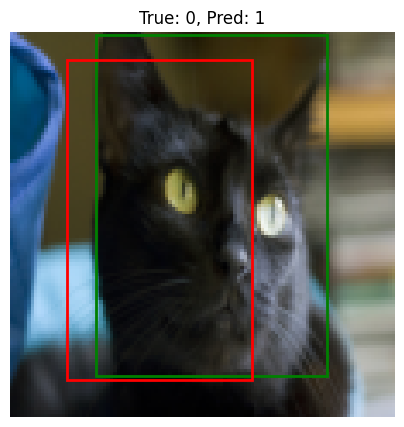

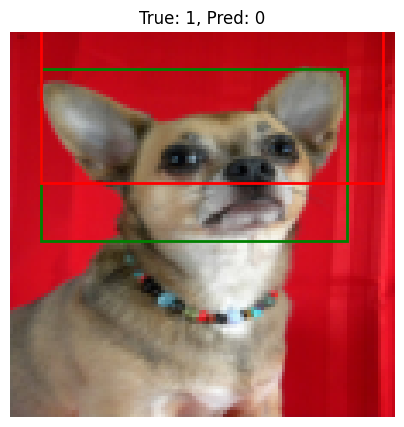

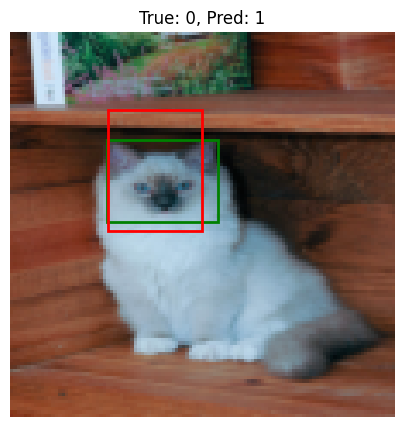

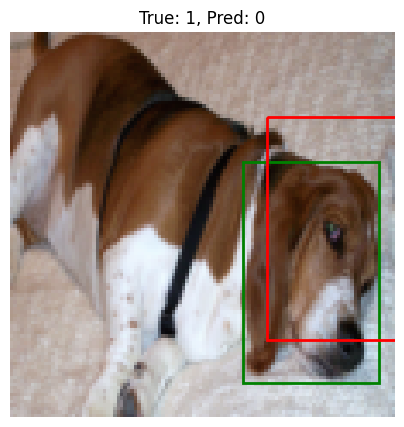

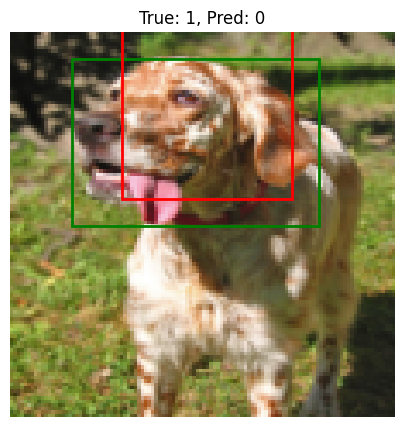

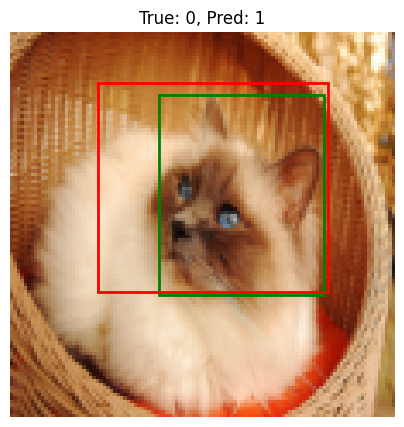

tensor(0.0787)

In [ ]:
model = YOLO_like()
model.load_state_dict(torch.load("/yolo_pretrained.pt"))
model.eval()
evaluate(model, test_dl, conf=0, iou=0.4, device="cpu")